In [1]:
from forge import *
from puzzle.puzzlepedia import prod_config

prod_config.init()

In [2]:
import cv2
import glob
import itertools
import importlib
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
from os import path
from sklearn.neighbors import NearestNeighbors
from typing import Iterable, Tuple

from data import data
from util import perf
from util.geometry import np2d
from data.image import coloring, component, component_database, image, utils
from puzzle.problems.image import image_problem
from puzzle.steps.image import decompose

importlib.reload(image)
importlib.reload(np2d)
importlib.reload(utils)
importlib.reload(coloring)


_FILE_PATTERN = '*.png'
_MAX = 255
_WHITE = [_MAX, _MAX, _MAX]
_THRESHOLD = 5
_SIZES = []
_FOCUS = {
}
pos = 16
for backwards in range(-1, -11, -1):
  for _ in range(0, 8):
    _SIZES.append(pos)
    pos += 1
  _SIZES.append(16 + backwards)

  
def image_path(name: str, subdir: str = 'original') -> str:
  return path.join(data.project_path('data/grid'), subdir, name)


def get_img(name, subdir: str = 'original'):
  # download the image, convert it to a NumPy array, and then read
  # it into OpenCV format
  return cv2.imread(image_path(name, subdir=subdir), flags=cv2.IMREAD_UNCHANGED)


def get_image(name):
  return image.Image(get_img(name))


def show(label, img=None):
  if img is None:
    img = label
  else:
    print(label)
  display(Image.fromarray(np.array(img, dtype=np.uint8)))


def show_components(g):
  db = component_database.ComponentDatabase()

  shown = set()
  for c in g.components:
    identified = db.identify(c)
    symbol = identified.labels.get('symbol')
    if symbol is None:
      pass
    elif symbol in shown:
      continue
    shown.add(symbol)
    show(c.image)


def imgs(subdir: str = 'original') -> Iterable[np.ndarray]:
  for filename in sorted(glob.glob(image_path(_FILE_PATTERN, subdir))):
    name = path.basename(filename)
    if _FOCUS and name not in _FOCUS:
      continue
    yield (
      name,
      cv2.imread(filename, flags=cv2.IMREAD_UNCHANGED))


def images() -> Iterable[image.Image]:
  for name, img in imgs():
    if _FOCUS and name not in _FOCUS:
      continue
    yield name, image.Image(img)
    
_PADDING = 8


def study(*segments, padding=_PADDING):
  """Studies line segments."""
  segments = [np.array(s) for s in segments]
  min_x = min(s[:, 0].min() for s in segments)
  min_y = min(s[:, 1].min() for s in segments)
  move_to_zero = np.array([min_x, min_y])
  for s in segments:
    print(repr(s))
    s -= move_to_zero - padding
  max_x = int(max(s[:, 0].max() for s in segments) + padding)
  max_y = int(max(s[:, 1].max() for s in segments) + padding)
  image = np.zeros((max_y + 1, max_x + 1, 3), dtype=np.uint8)
  colors = coloring.colors(len(segments))
  for s, color in zip(segments, colors):
    cv2.line(image, tuple(map(int, s[0])), tuple(map(int, s[1])), color.tolist(), 1)
  image = cv2.resize(image, None, fx=2, fy=2)
  show(image)
  return image


def study_contour(*contours, padding=_PADDING):
  """Studies contours."""
  colors = coloring.colors(len(contours))
  normalized = []
  for contour in contours:
    if len(contour.shape) > 2:
      size = contour.size
      contour = contour.view()
      contour.shape = (size // 2, 2)
    normalized.append(contour)
  contours = normalized
  min_x = min(c[:, 0].min() for c in contours) - padding
  min_y = min(c[:, 1].min() for c in contours) - padding
  max_x = max(c[:, 0].max() for c in contours) + padding - min_x
  max_y = max(c[:, 1].max() for c in contours) + padding - min_y
  move_to_zero = (-min_x, -min_y)
  image = np.zeros((max_y + 1, max_x + 1, 3), dtype=np.uint8)
  for contour, color in zip(contours, colors):
    #if len(contour) <= 1:
    #  continue
    contour.shape = (contour.size // 2, 1, 2)
    cv2.fillPoly(image, contour, color.tolist(), offset=move_to_zero)
  image = cv2.resize(image, None, fx=2, fy=2)
  show(image)


class Contour(object):
  def __init__(self, name, original):
    self.name = name
    self.original = original
    self.moments = cv2.moments(original)
    self.area = self.moments['m00']
    if self.area:
      self.cX = int((self.moments["m10"] / self.moments["m00"]))
      self.cY = int((self.moments["m01"] / self.moments["m00"]))
    else:
      self.cX = 0
      self.cY = 0
    self.center = np.array((self.cX, self.cY))
    self.perimeter = cv2.arcLength(original, True)
    if self.area > 5000:
      perimeter_scale = .005
    else:
      perimeter_scale = .05
    self.approx = cv2.approxPolyDP(original, perimeter_scale * self.perimeter, True)    
    self.convex = cv2.isContourConvex(self.approx)

  def draw_on(self, image, color=(0, 255, 0), bold=False):
    cv2.drawContours(image, [self.approx], -1, color, 1)
    if bold:
      font_weight = 2
    else:
      font_weight = 1
    cv2.putText(
      image, self.name, (self.cX - 9, self.cY + 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), font_weight)


def segment_interesting(c1, c2, s):
  length = np2d.point_to_point_distance(*s)
  min_perimeter = min(c1.perimeter, c2.perimeter)
  if length / min_perimeter < .01:
    return False
  if not c1.convex or not c2.convex:
    return True
  return np2d.segments_intersect((c1.center, c2.center), s)


def wall_segments(c1, c2):
  result = []
  for s1 in np2d.iter_segments(c1.approx):
    if not segment_interesting(c1, c2, s1):
      continue
    for s2 in np2d.iter_segments(c2.approx):
      if not segment_interesting(c1, c2, s2):
        continue
      gap_threshold = np2d.point_to_point_distance(c1.center, c2.center) * 0.5
      p_overlap = np2d.overlap(s1, s2, gap_threshold=gap_threshold)
      overlap_ok = p_overlap > .5
      if overlap_ok:
        result.append((s1, s2, p_overlap))
      #else:
      #  study(s1, s2)
  return result


def n_siblings(hierarchy, start):
  count = 1
  next_sibling, previous_sibling, _, _ = hierarchy[start]
  while next_sibling >= 0:
    count += 1
    next_sibling, previous_sibling, _, _ = hierarchy[next_sibling]
    if next_sibling == start:
      break
  return count


def show_hierarchy(hierarchy, pos=0, indent=''):
  while pos != -1:
    next_sibling, previous_sibling, child, parent = hierarchy[pos]
    if child:
      siblings = n_siblings(hierarchy, child)
      if siblings > 1:
        siblings_suffix = ' (%d)' % siblings
      else:
        siblings_suffix = ''
    if next_sibling == -1:
      print_indent = indent.replace('├', '└')
    else:
      print_indent = indent
    print('%s─ %s%s' % (print_indent, pos, siblings_suffix))
    if child:
      show_hierarchy(hierarchy, pos=child, indent=indent.replace('├', '│')+'  ├')
    pos = next_sibling


def process_contours(contours, hierarchy, pos, acc, area_threshold):
  #if n_siblings(hierarchy, pos) > 5:
  siblings, area = create_contour_instances(contours, hierarchy, pos, acc)
  if area > area_threshold:
    sibling_area_threshold = area / 1000
    filtered = [sibling for sibling in siblings if sibling.area > sibling_area_threshold]
    if len(filtered) > 5:
      acc.extend(filtered)
  while pos != -1:
    pos, _, child, _ = hierarchy[pos]
    if child:
      process_contours(contours, hierarchy, child, acc, area_threshold)
  return acc


def create_contour_instances(contours, hierarchy, pos, acc):
  total_area = 0
  result = []
  while pos != -1:
    contour_instance = Contour(str(pos), contours[pos])
    if contour_instance.area:
      total_area += contour_instance.area
      result.append(contour_instance)
    pos, _, _, _ = hierarchy[pos]
  return result, total_area


working on arrow.png (414x373)


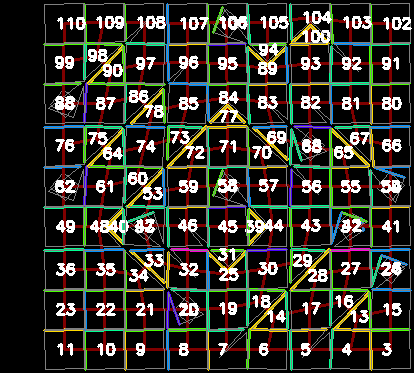

working on askew.png (420x364)


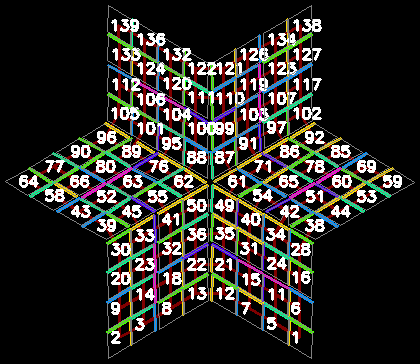

working on cages.png (723x723)


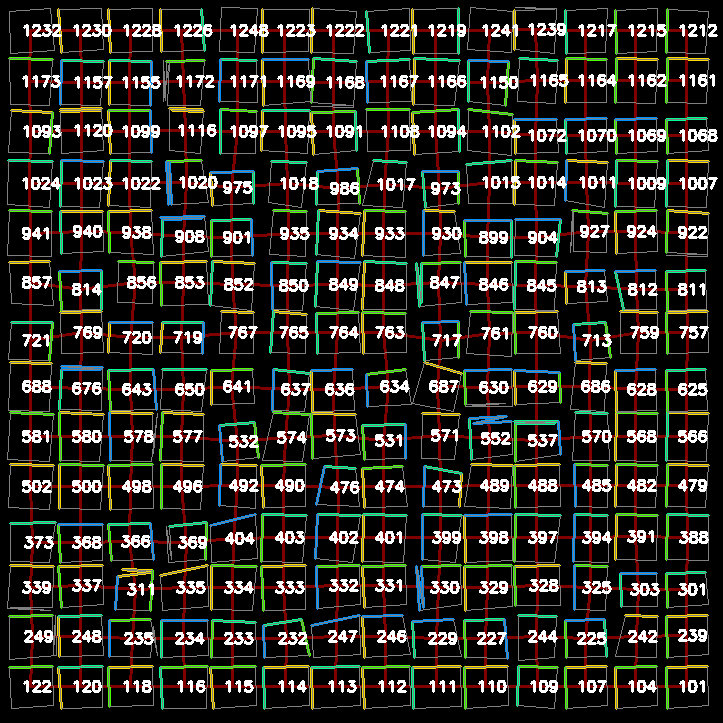

working on castlewall.png (437x403)


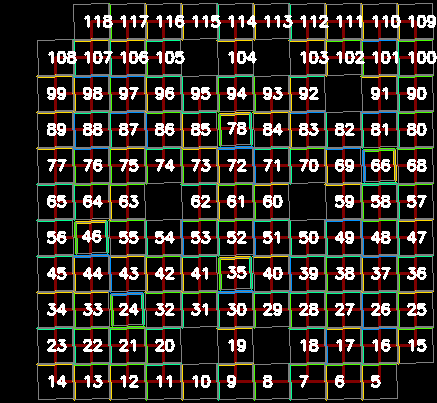

working on crossword.png (546x546)


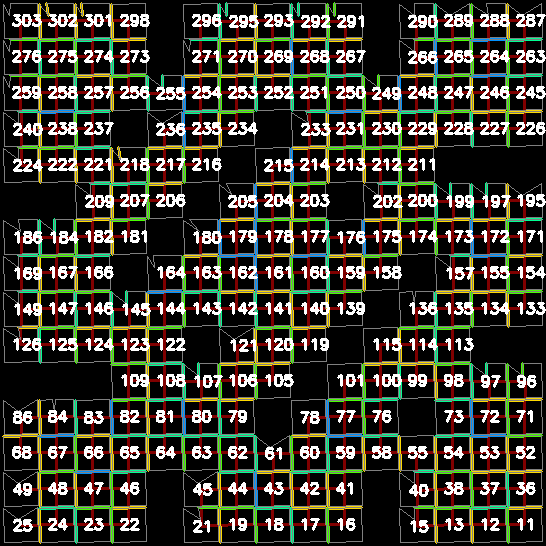

working on fillomino.png (485x485)
filter removed all contours
working on kakuro.png (397x431)


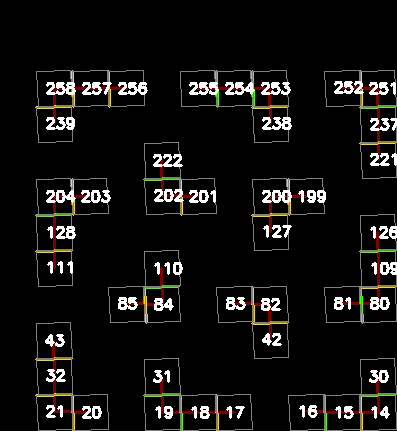

working on kenken.png (500x500)


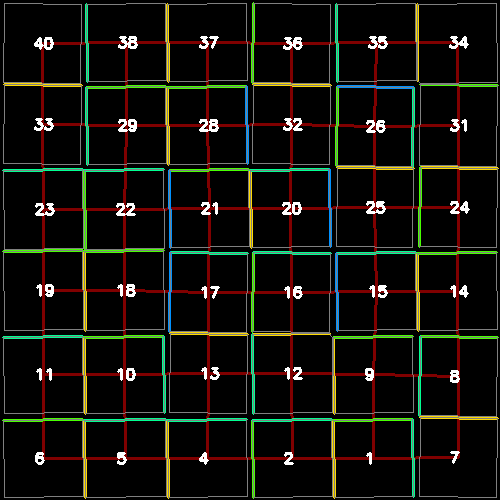

working on masyu.png (469x437)
filter removed all contours
working on multi.png (487x487)


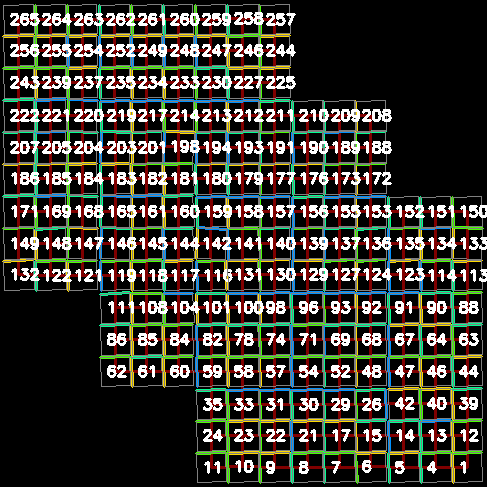

working on nonogram.png (1438x1361)


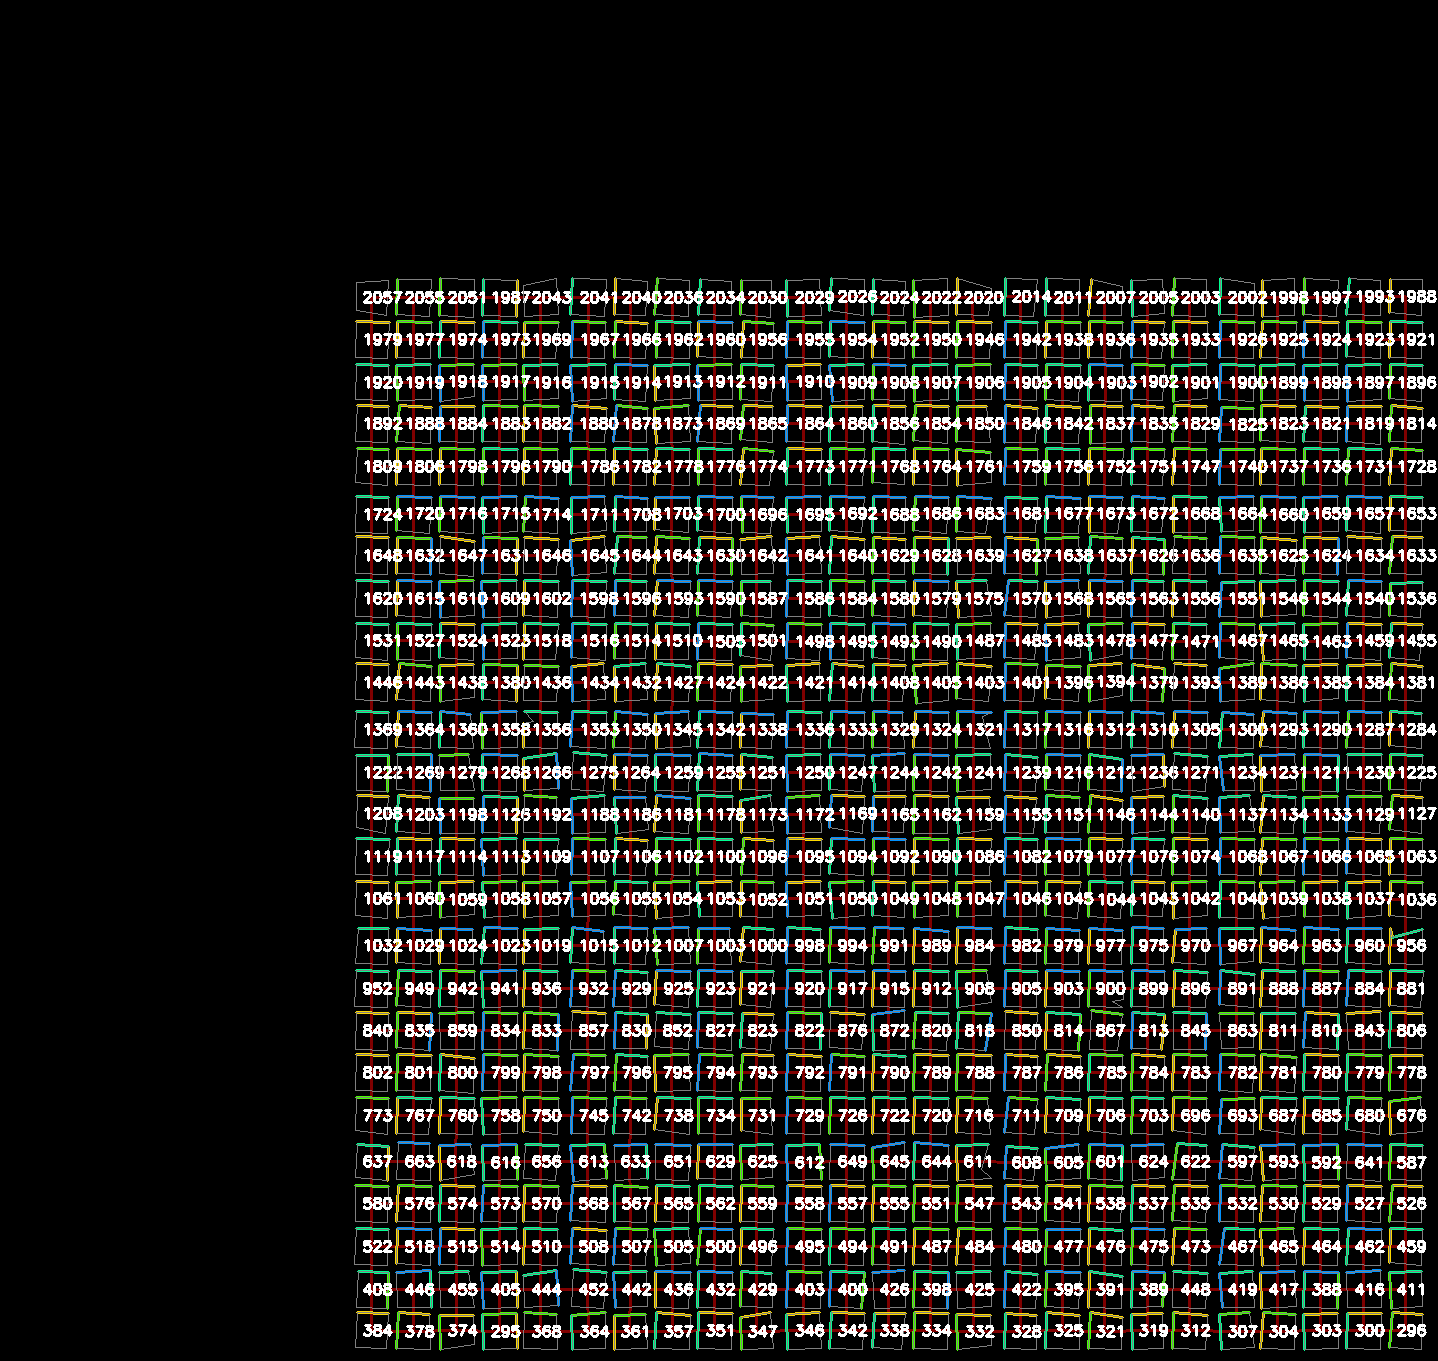

working on nurimaze.png (1593x1593)


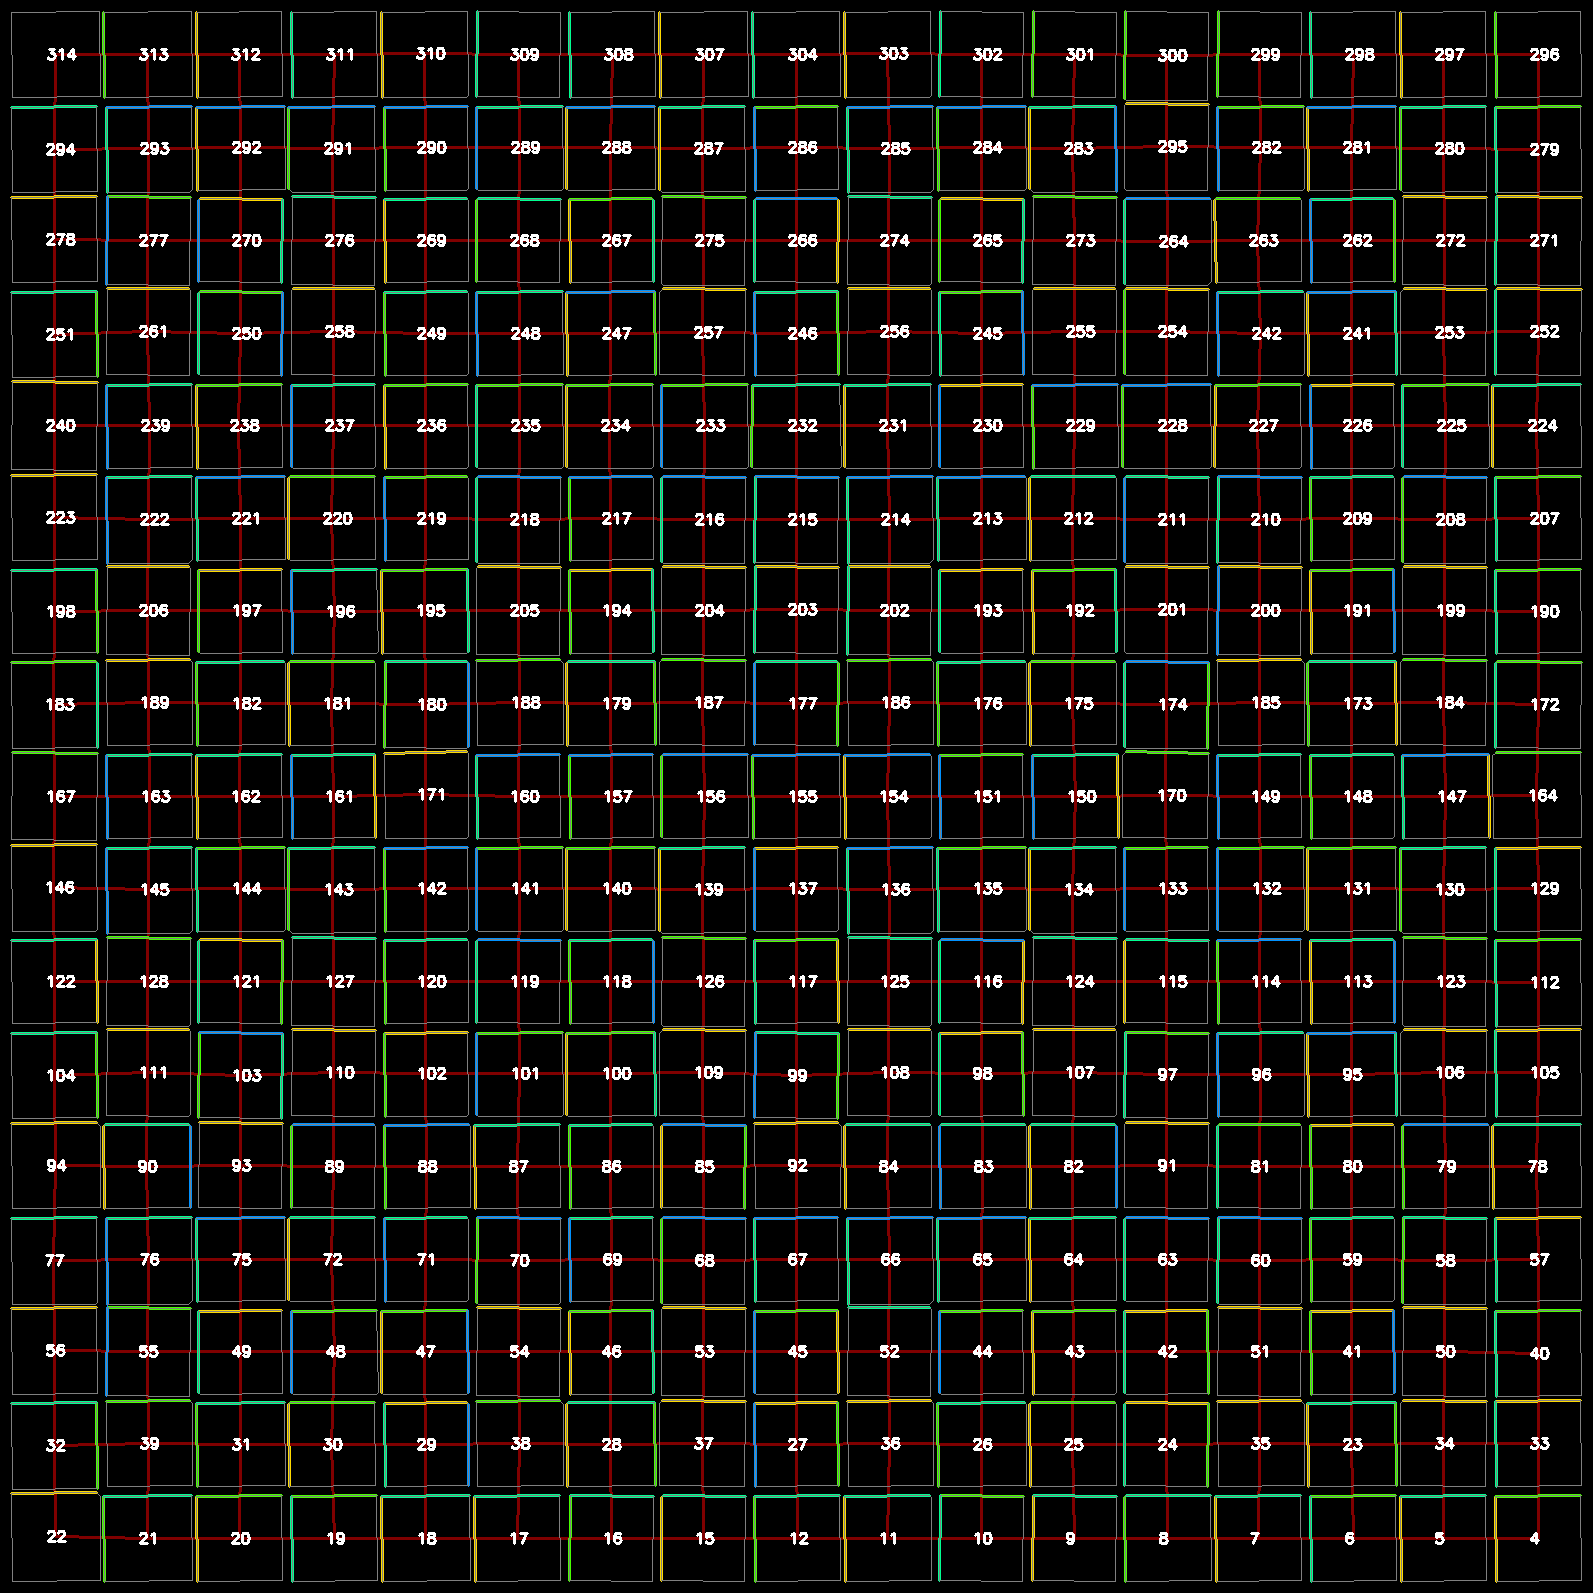

working on pentopia.png (509x792)


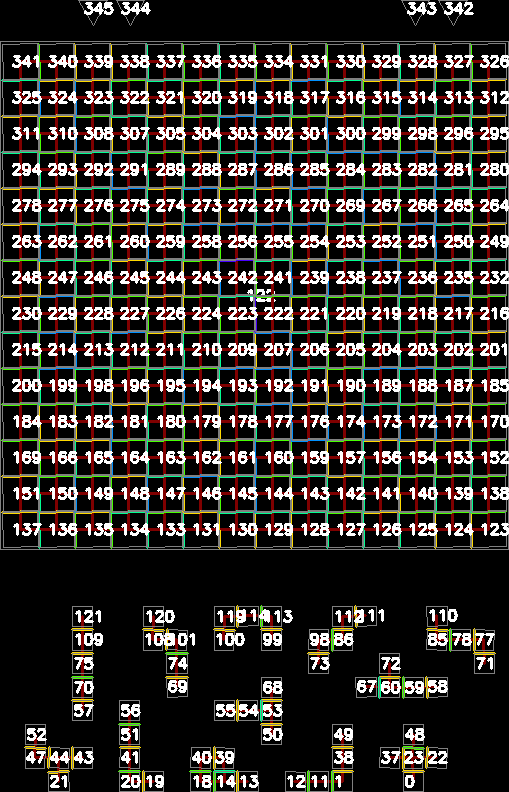

working on skyscraper.png (281x287)


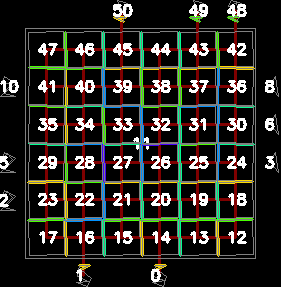

working on slitherlink.png (375x339)
filter removed all contours
working on spiral.png (1438x1485)


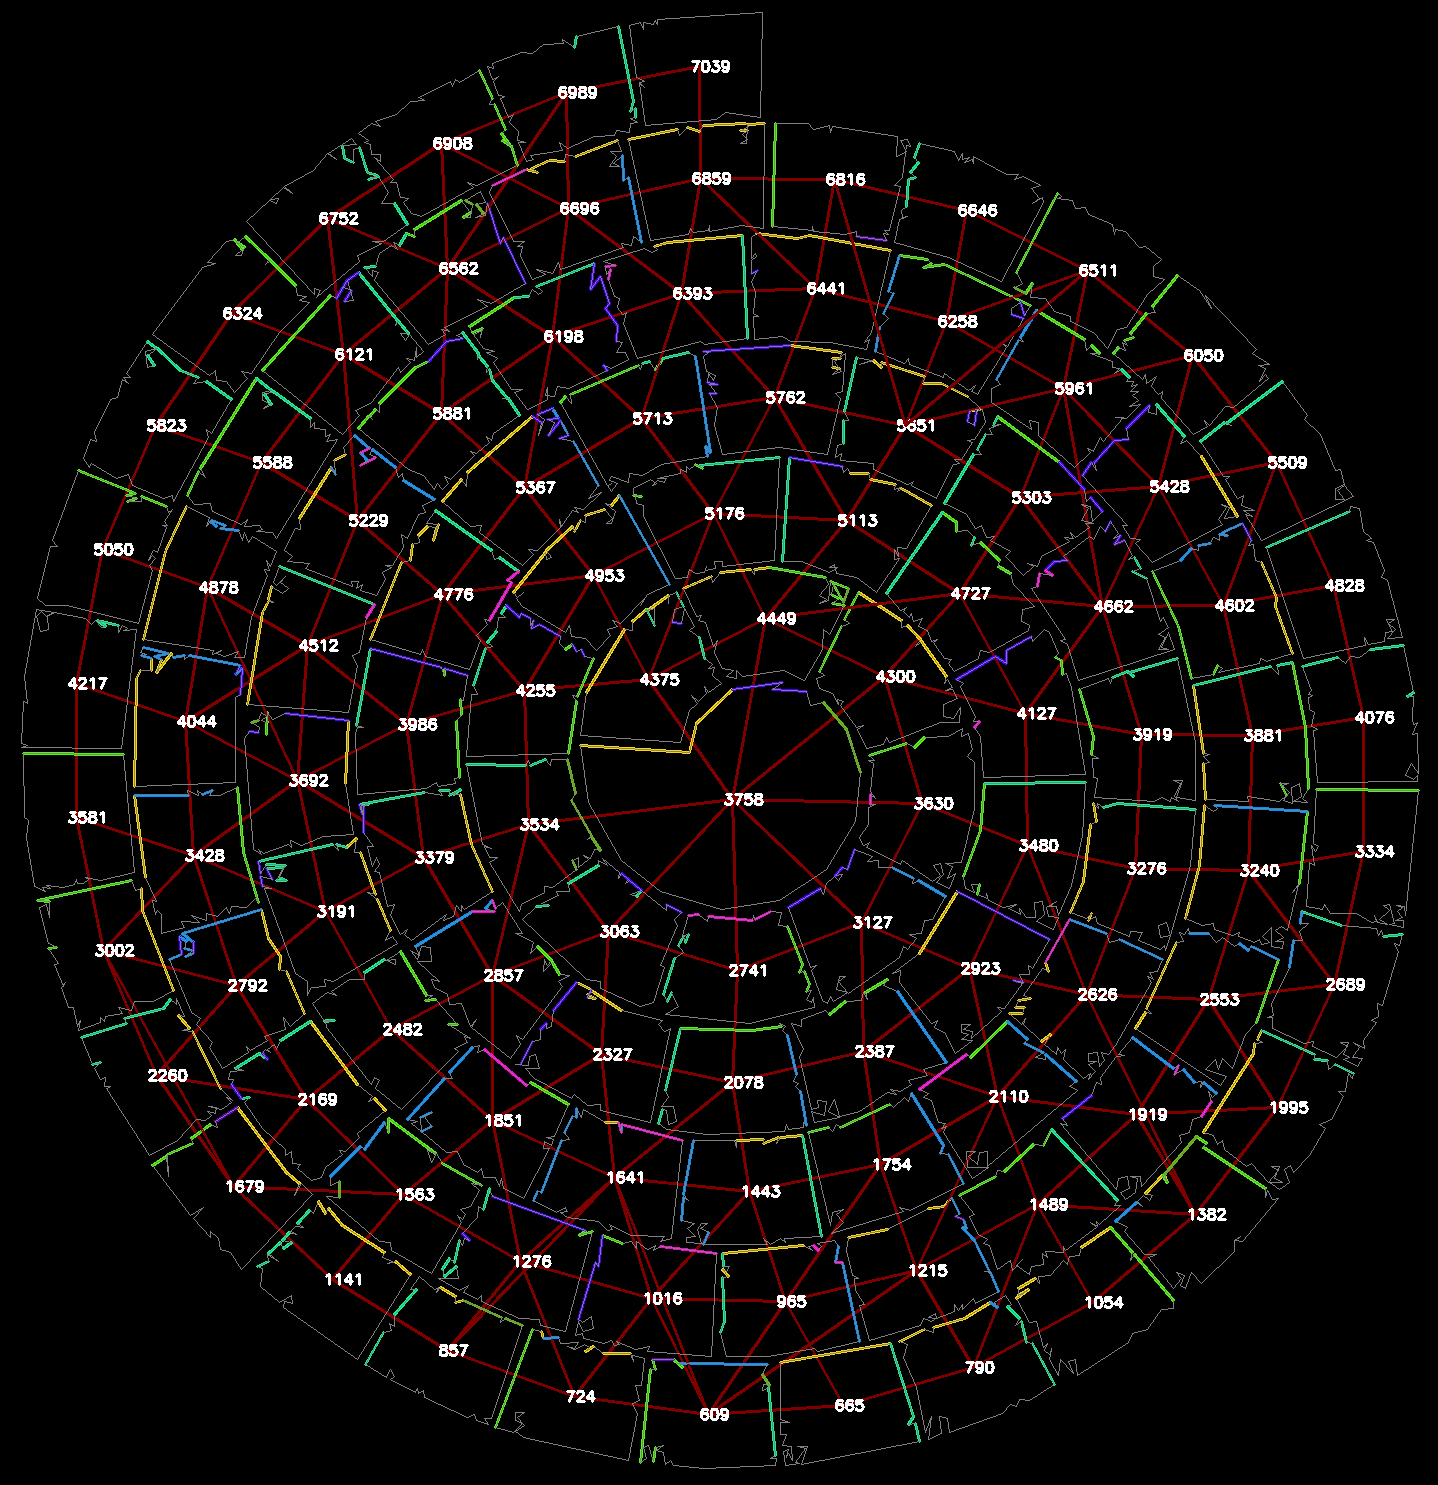

working on strimko.png (205x205)
filter removed all contours
working on thermo.png (551x611)


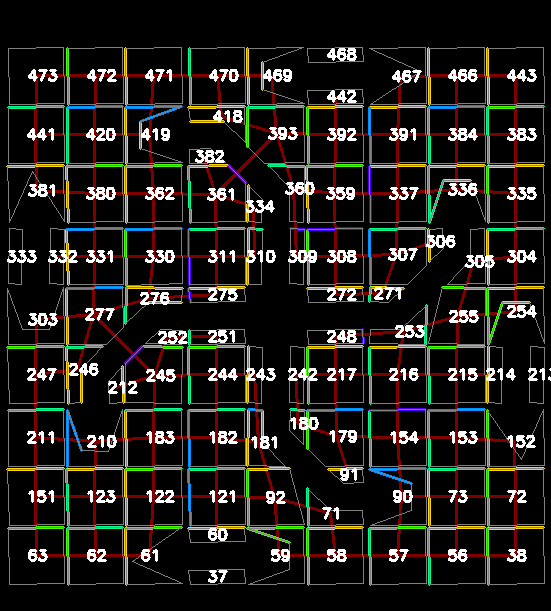

working on wordsearch.png (603x603)


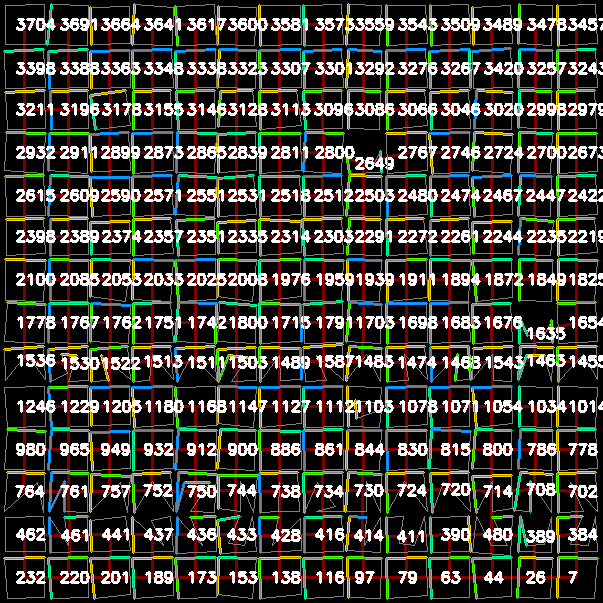

working on wordsearch_with_bank.png (744x1180)
filter removed all contours
process
grid:                 0 (0 calls)
load:                 0 (0 calls)
contours:             29.81/s, 1.00x (20 calls, 670.89u)
findContours:         276.98/s, 9.29x (20 calls, 72.21u)
wall_segments:        584.95/s, 19.62x (11021 calls, 18841.05u)
neighbors.fit:        624.46/s, 20.95x (15 calls, 24.02u)
neighbors.kneighbors: 3213.64/s, 107.80x (2572 calls, 800.34u)
drawing:              149332.45/s, 5009.25x (11021 calls, 73.80u)
dedupe:               347550.35/s, 11658.33x (23148 calls, 66.60u)


In [74]:
process = perf.Perf('process', [
  'contours', 'dedupe', 'drawing', 'findContours', 'grid', 'load', 'neighbors.fit', 'neighbors.kneighbors', 'wall_segments'])

_FOCUS = {
  #'askew.png': {
    #79, 56,
  #},
  #'castlewall.png': {
    #66, 73
  #},
}
for n, i in imgs():
  p = image_problem.ImageProblem(n, i)
  focus_points = _FOCUS.get(n)

  src = p._decompose.get_result().get_debug_data()

  height, width = src.shape
  area_threshold = (width * height) / 4  # Maximum allowed empty space.
  print('working on %s (%dx%d)' % (n, width, height))

  with process['findContours']:
    im2, contours, hierarchy = cv2.findContours(src, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  hierarchy = hierarchy.reshape(hierarchy.shape[-2:])
  #print(hierarchy)
  #show_hierarchy(hierarchy)

  with process['contours']:
    filtered = process_contours(contours, hierarchy, 0, [], area_threshold)

  if not filtered:
    print('filter removed all contours')
    continue

  n_neighbors = 9  # Assumes 3x3 grid of 2d squares.
  with process.benchmark('neighbors.fit'):
    neighbors = NearestNeighbors(n_neighbors)  
    neighbors.fit([(c.cX, c.cY) for c in filtered])

  # 840 / 701.71u -> 479 / 388.37u.
  visited = set()
  image = np.zeros((height, width, 3), np.uint8)
  for target in filtered:
    focused = not focus_points or int(target.name) in focus_points
    with process.benchmark('neighbors.kneighbors'):
      d, n = neighbors.kneighbors([(target.cX, target.cY)], n_neighbors=n_neighbors)
    colors = coloring.colors(n_neighbors)
    for dist, pos, color in zip(*d, *n, colors):
      color = color.tolist()
      c = filtered[pos]
      if focus_points and int(c.name) not in focus_points:
        continue
      with process['dedupe']:
        if c.name < target.name:
          key = '%s:%s' % (c.name, target.name)
        else:
          key = '%s:%s' % (target.name, c.name)
        dupe = key in visited
      if dupe:
        continue
      visited.add(key)
      if dist:
        with process.benchmark('wall_segments'):
          segments = wall_segments(target, c)
        if segments:
          cv2.line(image, (target.cX, target.cY), (c.cX, c.cY), (128, 0, 0), 2)
        #  print('%s -> %s: %s' % (c.name, target.name, len(segments)))
        with process['drawing']:
          for s1, s2, _ in segments:
            cv2.line(image, tuple(s1[0]), tuple(s1[1]), color, 2)
            #cv2.line(image, tuple(s2[0]), tuple(s2[1]), color, 2)
    target.draw_on(image, color=(128, 128, 128), bold=focused)
  show(image)

print(process)


arrow.png 111


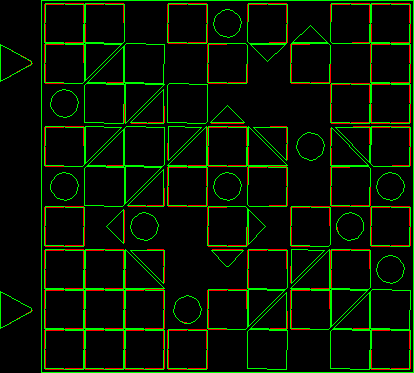

askew.png 141


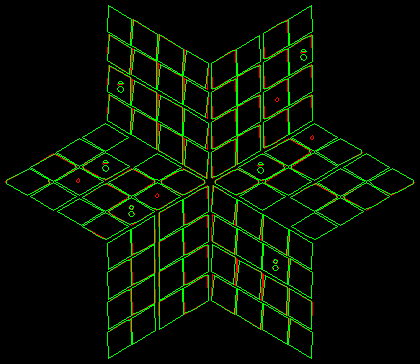

cages.png 1255


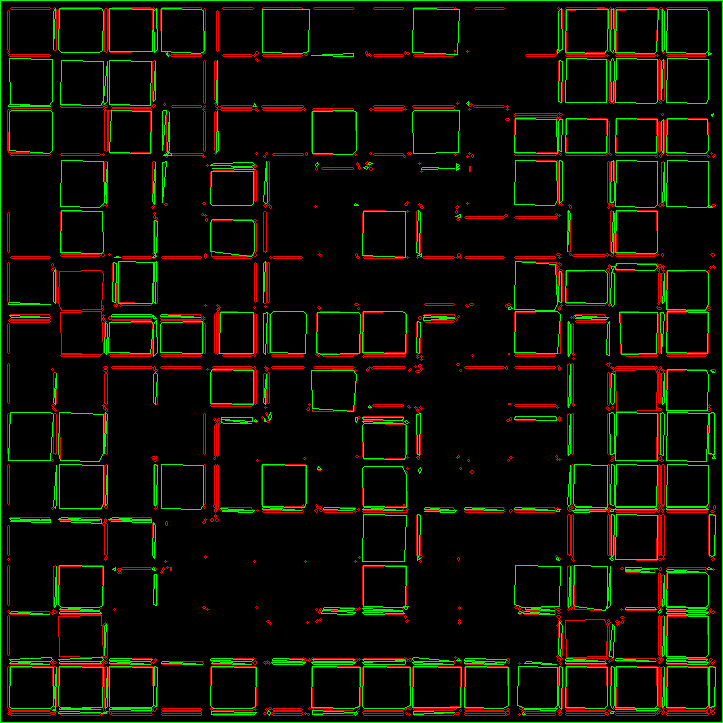

castlewall.png 119


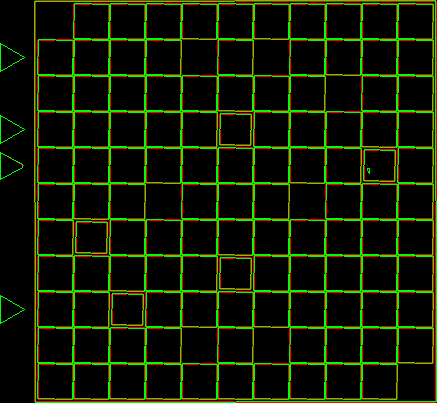

crossword.png 304


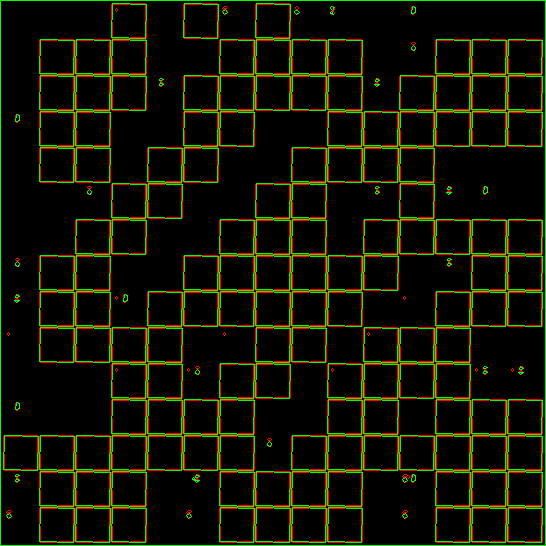

fillomino.png 623


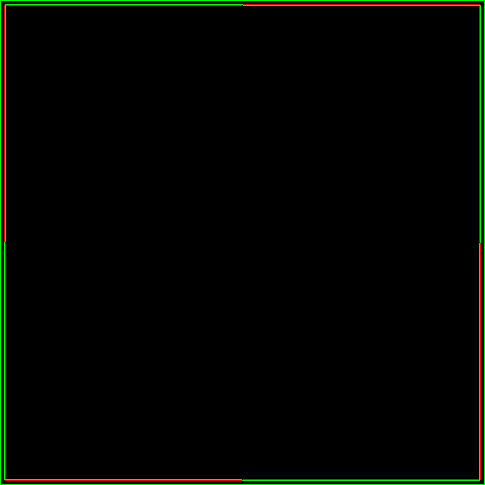

kakuro.png 287


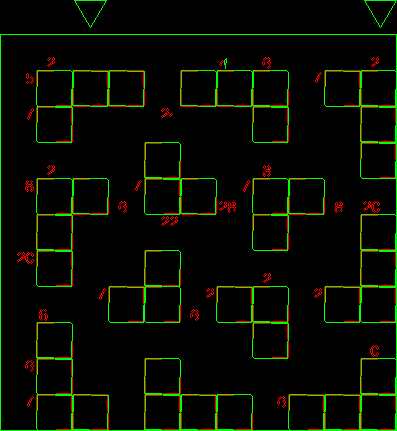

kenken.png 41


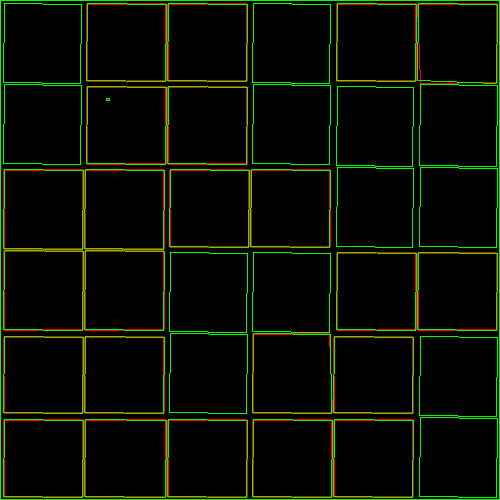

masyu.png 1462


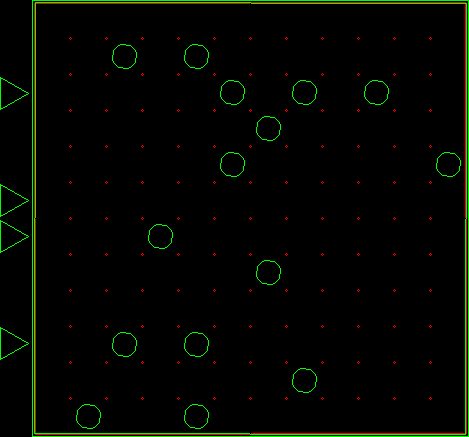

multi.png 267


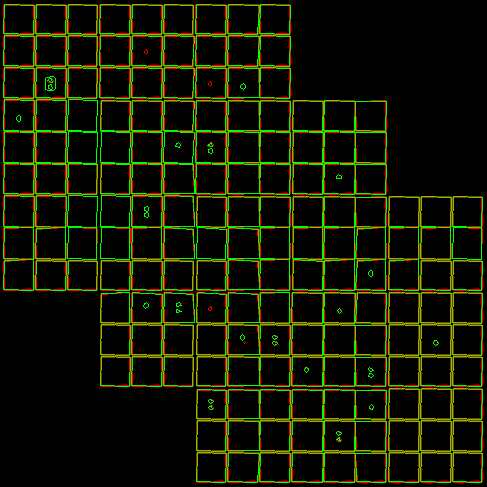

nonogram.png 2087


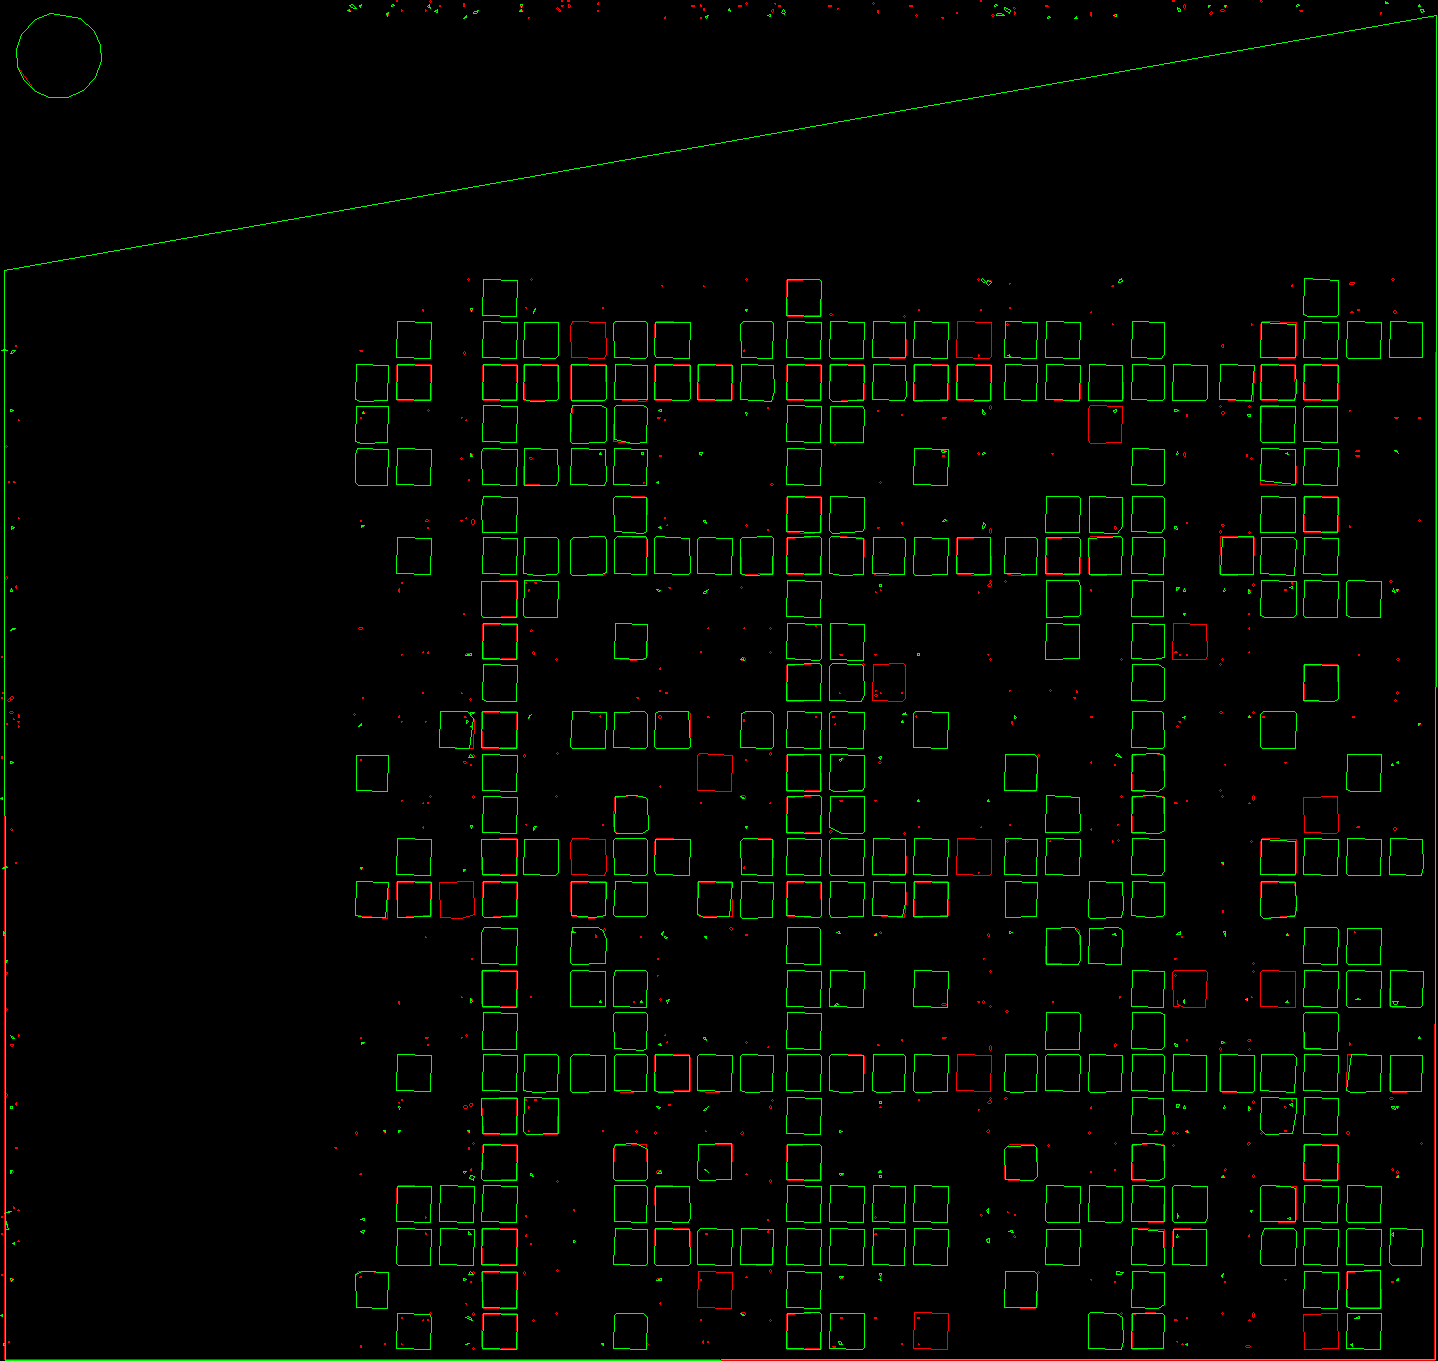

nurimaze.png 317


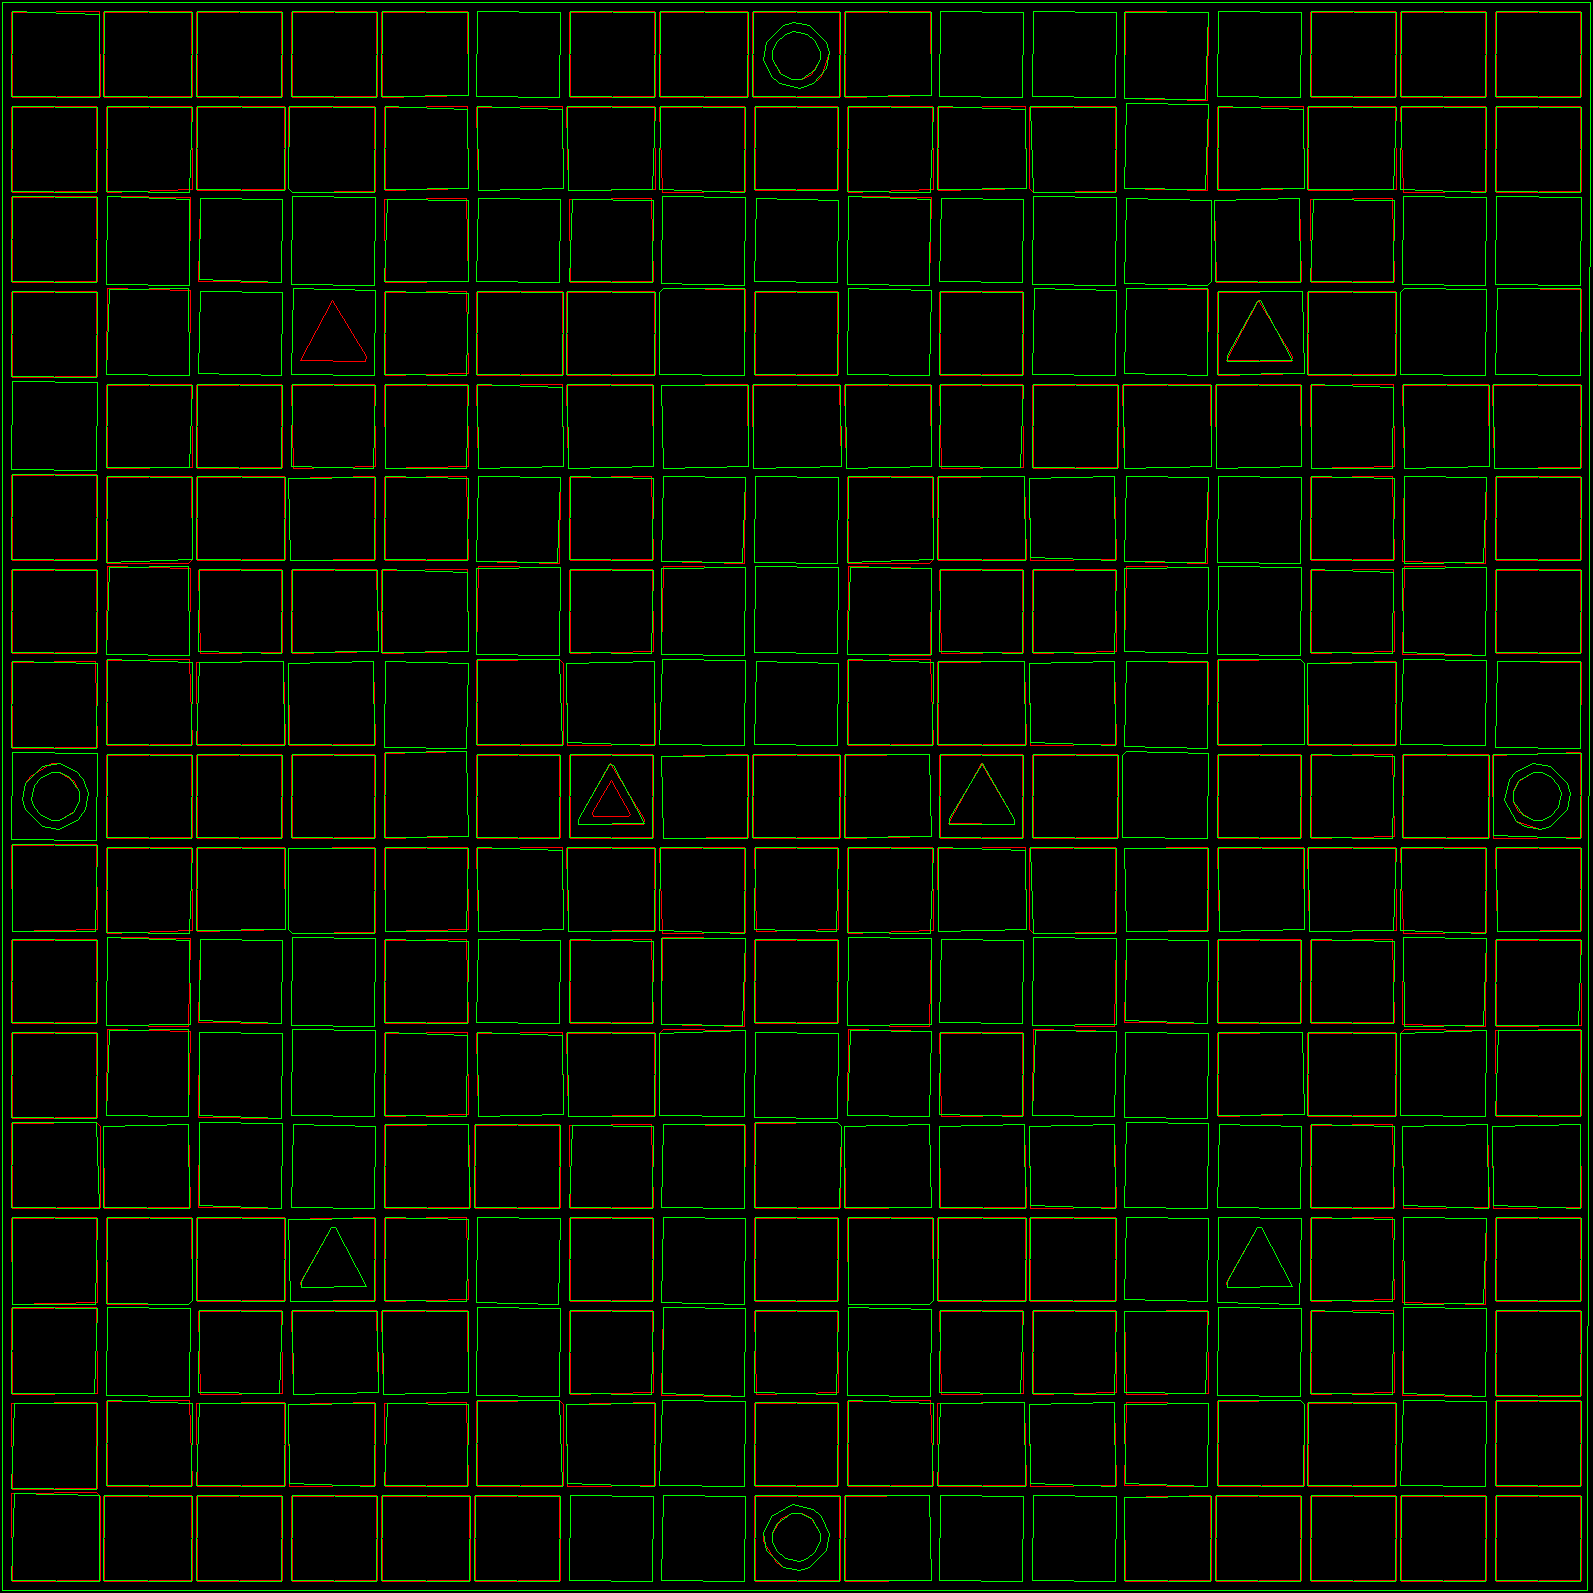

pentopia.png 346


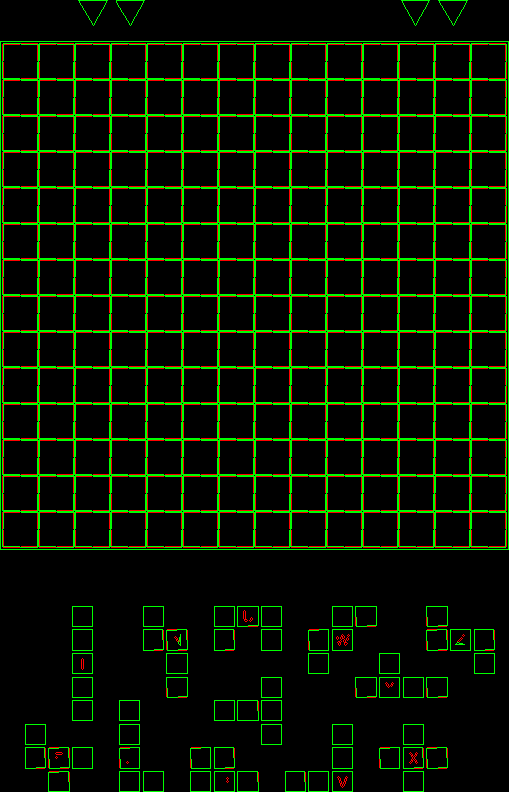

skyscraper.png 51


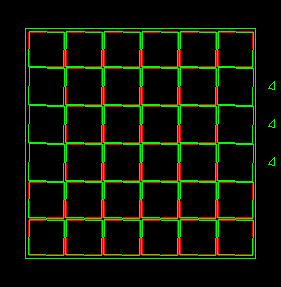

slitherlink.png 134


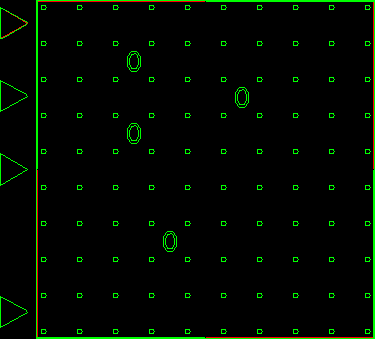

spiral.png 7075


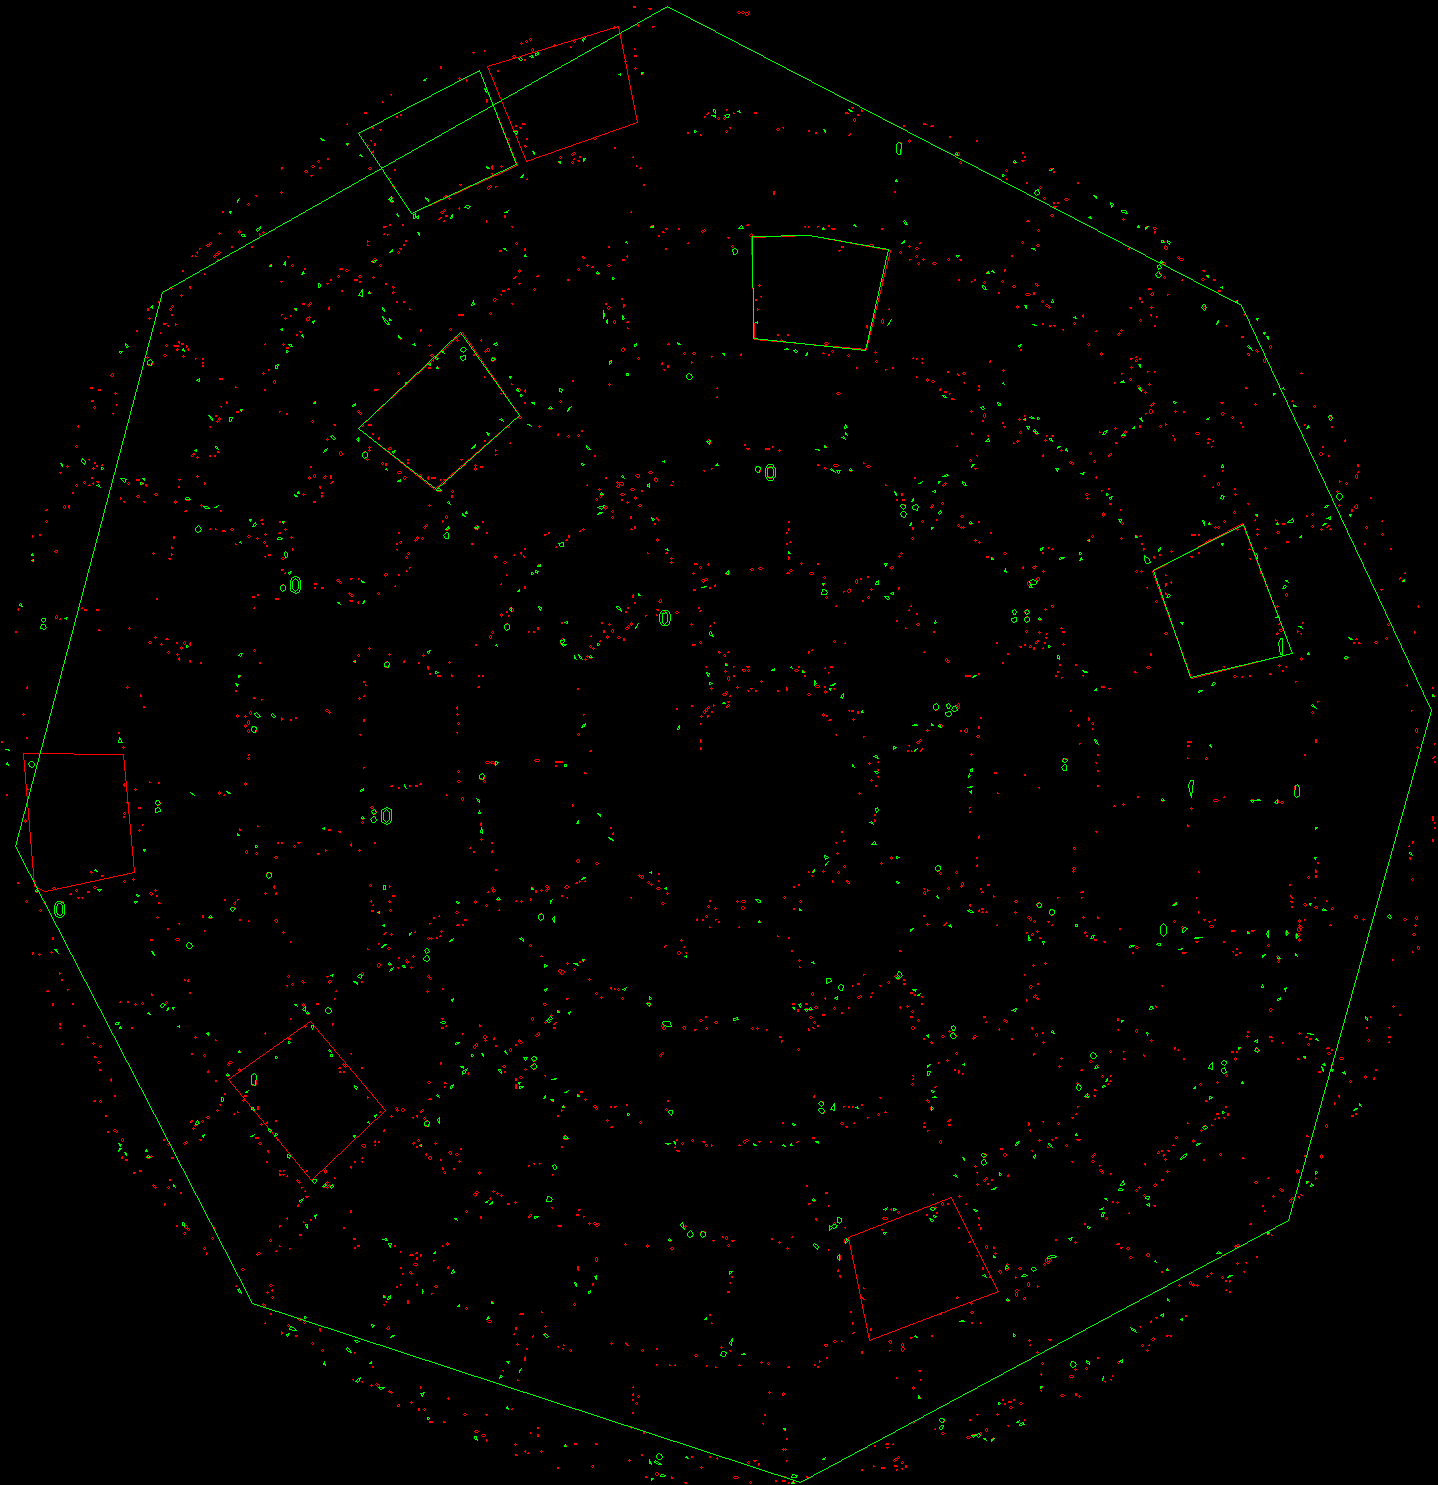

strimko.png 104


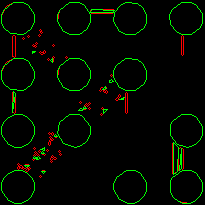

thermo.png 495


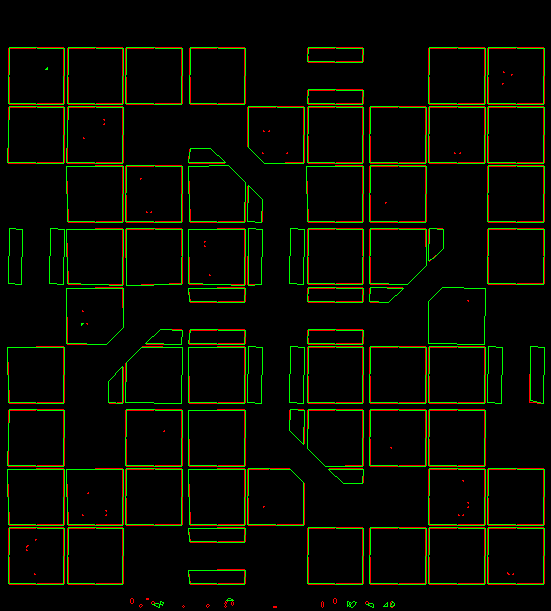

wordsearch.png 3744


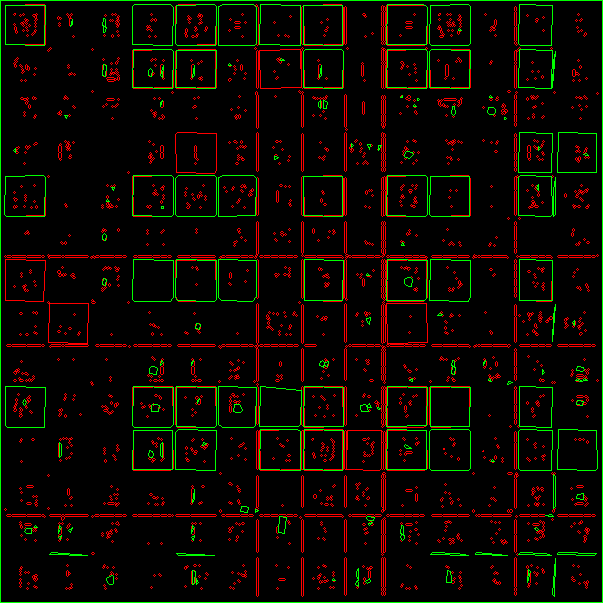

wordsearch_with_bank.png 508


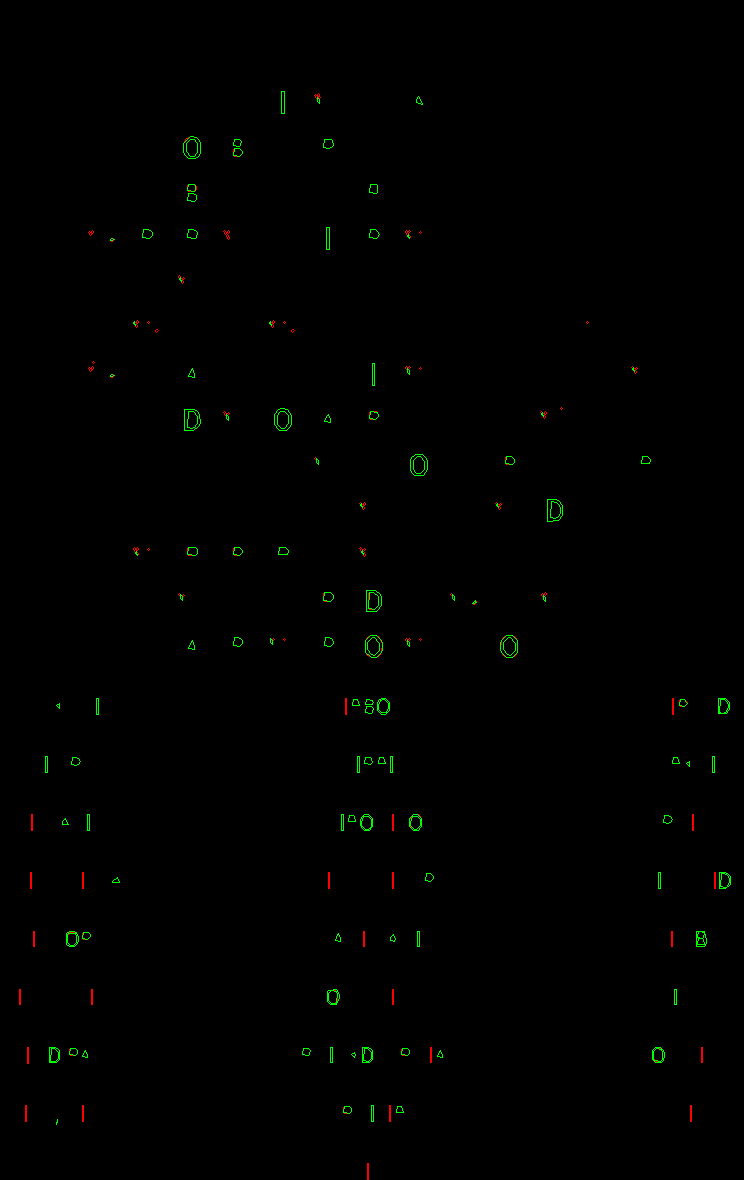

In [77]:
for n, i in imgs():
  p = image_problem.ImageProblem(n, i)

  src = p._decompose.get_result().get_debug_data()

  height, width = src.shape
  image = np.zeros((height, width, 3), np.uint8)
  im2, contours, hierarchy = cv2.findContours(src, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.01 * peri, True)
    if cv2.isContourConvex(approx):
      cv2.drawContours(image, [approx], -1, (255, 0, 0), 1)
  im2, contours, hierarchy = cv2.findContours(src, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1)
  for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.01 * peri, True)
    if cv2.isContourConvex(approx):
      cv2.drawContours(image, [approx], -1, (0, 255, 0), 1)
  print(n, len(contours))
  show(image)

Threshold terminated at 2 153
[0, 0, 7, 19, 65, 67, 72, 75, 77, 81, 82, 84, 86, 89, 91, 94, 99, 101, 106, 140, 142, 147, 149, 154, 157, 159, 164, 166, 171, 173, 176, 181, 183, 188, 229, 231, 241, 245, 244, 247, 246, 246, 249, 248, 248, 248, 251, 250, 250, 253, 252, 328, 330]
@ 0.00, with steps of 65.00: 5 divisions, 5 matches, (1 missing) 75 delta (15.00/div)
@ 0.00, with steps of 67.00: 4 divisions, 5 matches, (0 missing) 9 delta (2.25/div)
@ 0.00, with steps of 84.00: 3 divisions, 4 matches, (0 missing) 5 delta (1.67/div)
@ 0.00, with steps of 140.00: 2 divisions, 3 matches, (0 missing) 2 delta (1.00/div)
clustered: 0 51 / 52 2
intersections


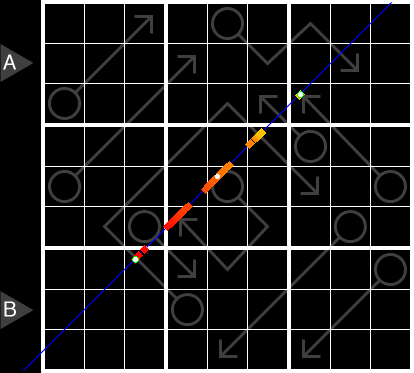

arrow.png


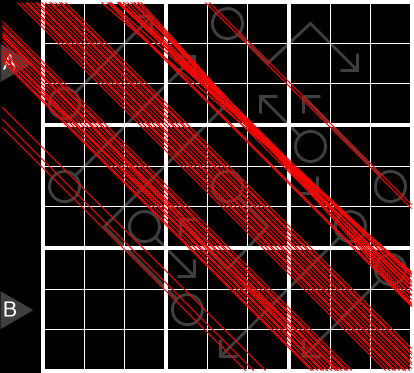

Threshold terminated at 2 135
[0, 0, 2, 2, 4, 6, 23, 23, 24, 25, 26, 27, 29, 30, 30, 34, 52, 53, 53, 55, 78, 79, 80, 81, 104, 106, 106, 108, 131, 132, 133, 134, 157, 158, 159, 160, 178, 179, 181, 182, 183, 185, 185, 186, 187, 206, 206, 206, 208, 209, 210, 212]
@ 0.00, with steps of 23.00: 9 divisions, 10 matches, (0 missing) 44 delta (4.89/div)
@ 0.00, with steps of 24.00: 8 divisions, 9 matches, (0 missing) 35 delta (4.38/div)
@ 0.00, with steps of 27.00: 7 divisions, 8 matches, (0 missing) 27 delta (3.86/div)
@ 0.00, with steps of 34.00: 6 divisions, 7 matches, (0 missing) 20 delta (3.33/div)
@ 0.00, with steps of 52.00: 4 divisions, 5 matches, (0 missing) 9 delta (2.25/div)
@ 0.00, with steps of 55.00: 3 divisions, 4 matches, (0 missing) 5 delta (1.67/div)
@ 0.00, with steps of 78.00: 2 divisions, 3 matches, (0 missing) 2 delta (1.00/div)
clustered: 0 32 / 51 2
intersections


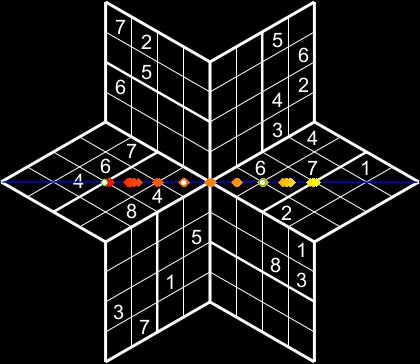

askew.png


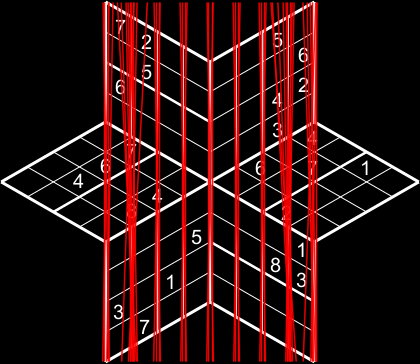

Threshold terminated at 3 50
[0, 0, 62, 128, 134, 202, 262, 403, 464, 532, 537, 605, 666, 806, 868, 934, 940, 1008, 1070]
@ 0.00, with steps of 62.00: 17 divisions, 15 matches, (3 missing) 310 delta (18.24/div)
@ 0.00, with steps of 128.00: 8 divisions, 9 matches, (0 missing) 35 delta (4.38/div)
@ 0.00, with steps of 202.00: 5 divisions, 6 matches, (0 missing) 14 delta (2.80/div)
@ 0.00, with steps of 262.00: 4 divisions, 5 matches, (0 missing) 9 delta (2.25/div)
@ 0.00, with steps of 403.00: 2 divisions, 3 matches, (0 missing) 2 delta (1.00/div)
clustered: 0 13 / 18 2
intersections


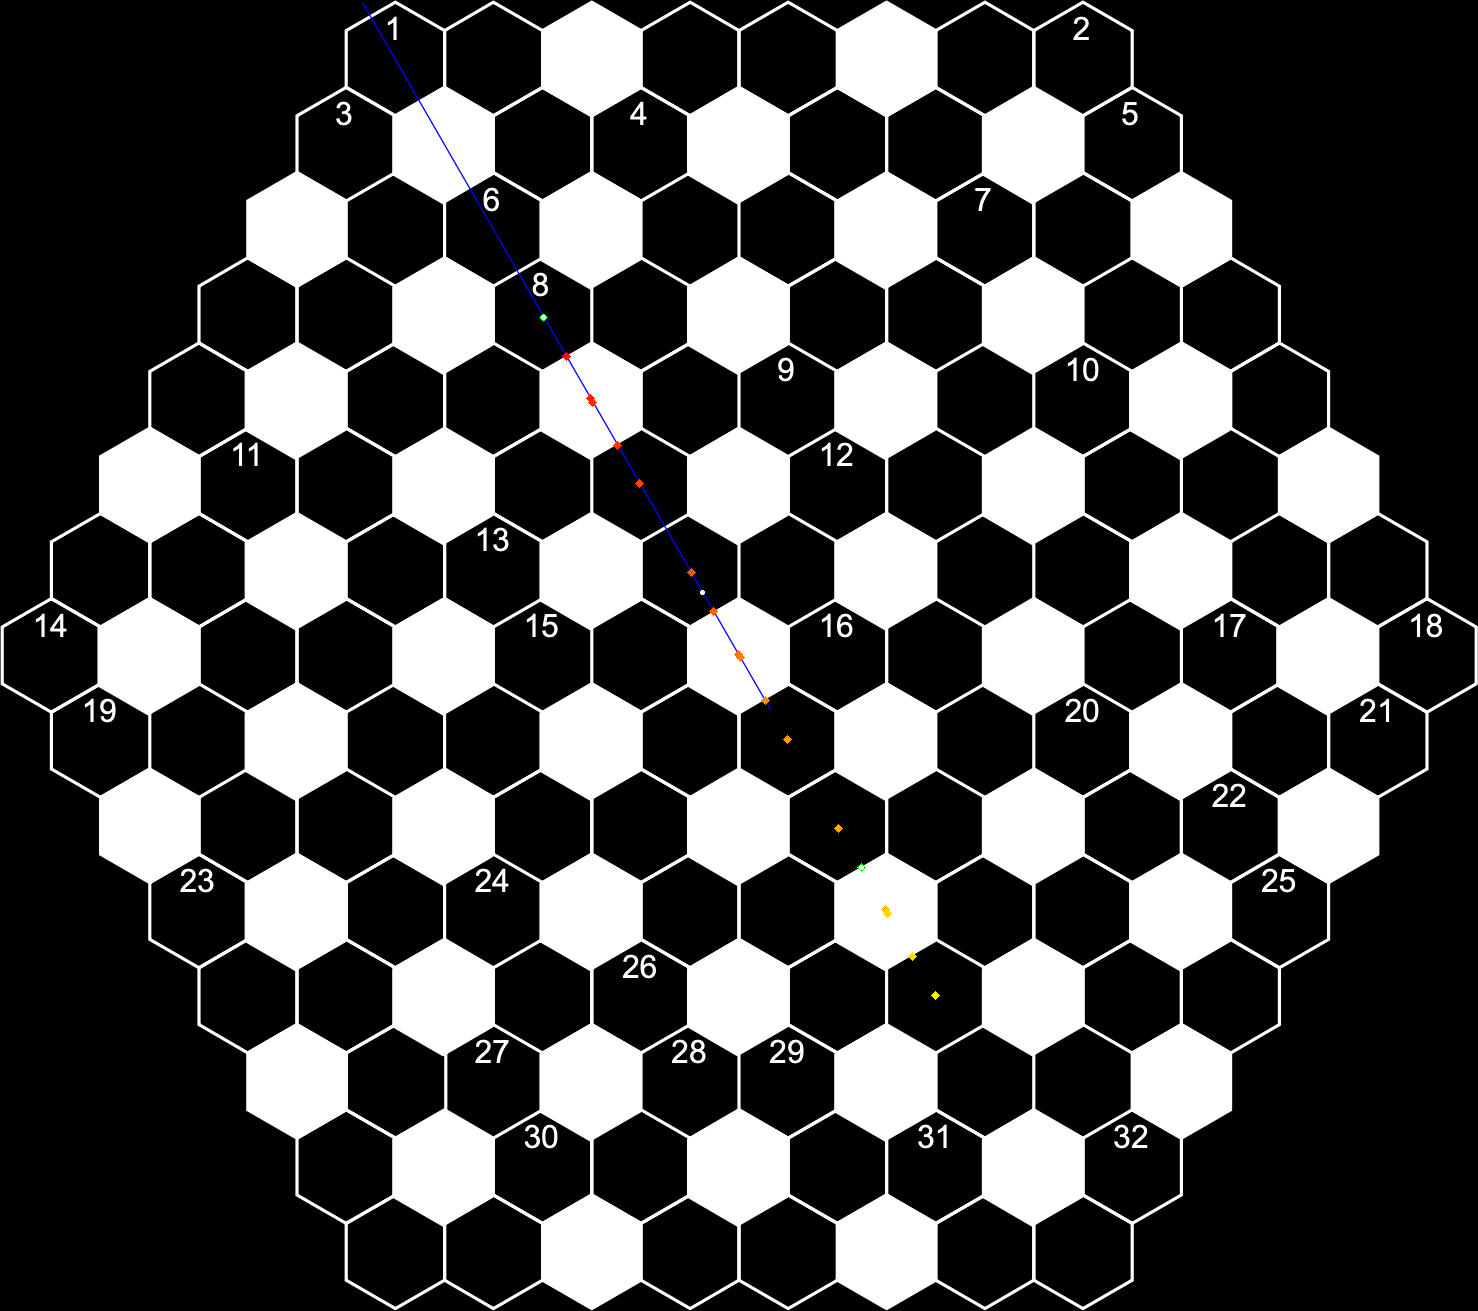

pathfinder.png


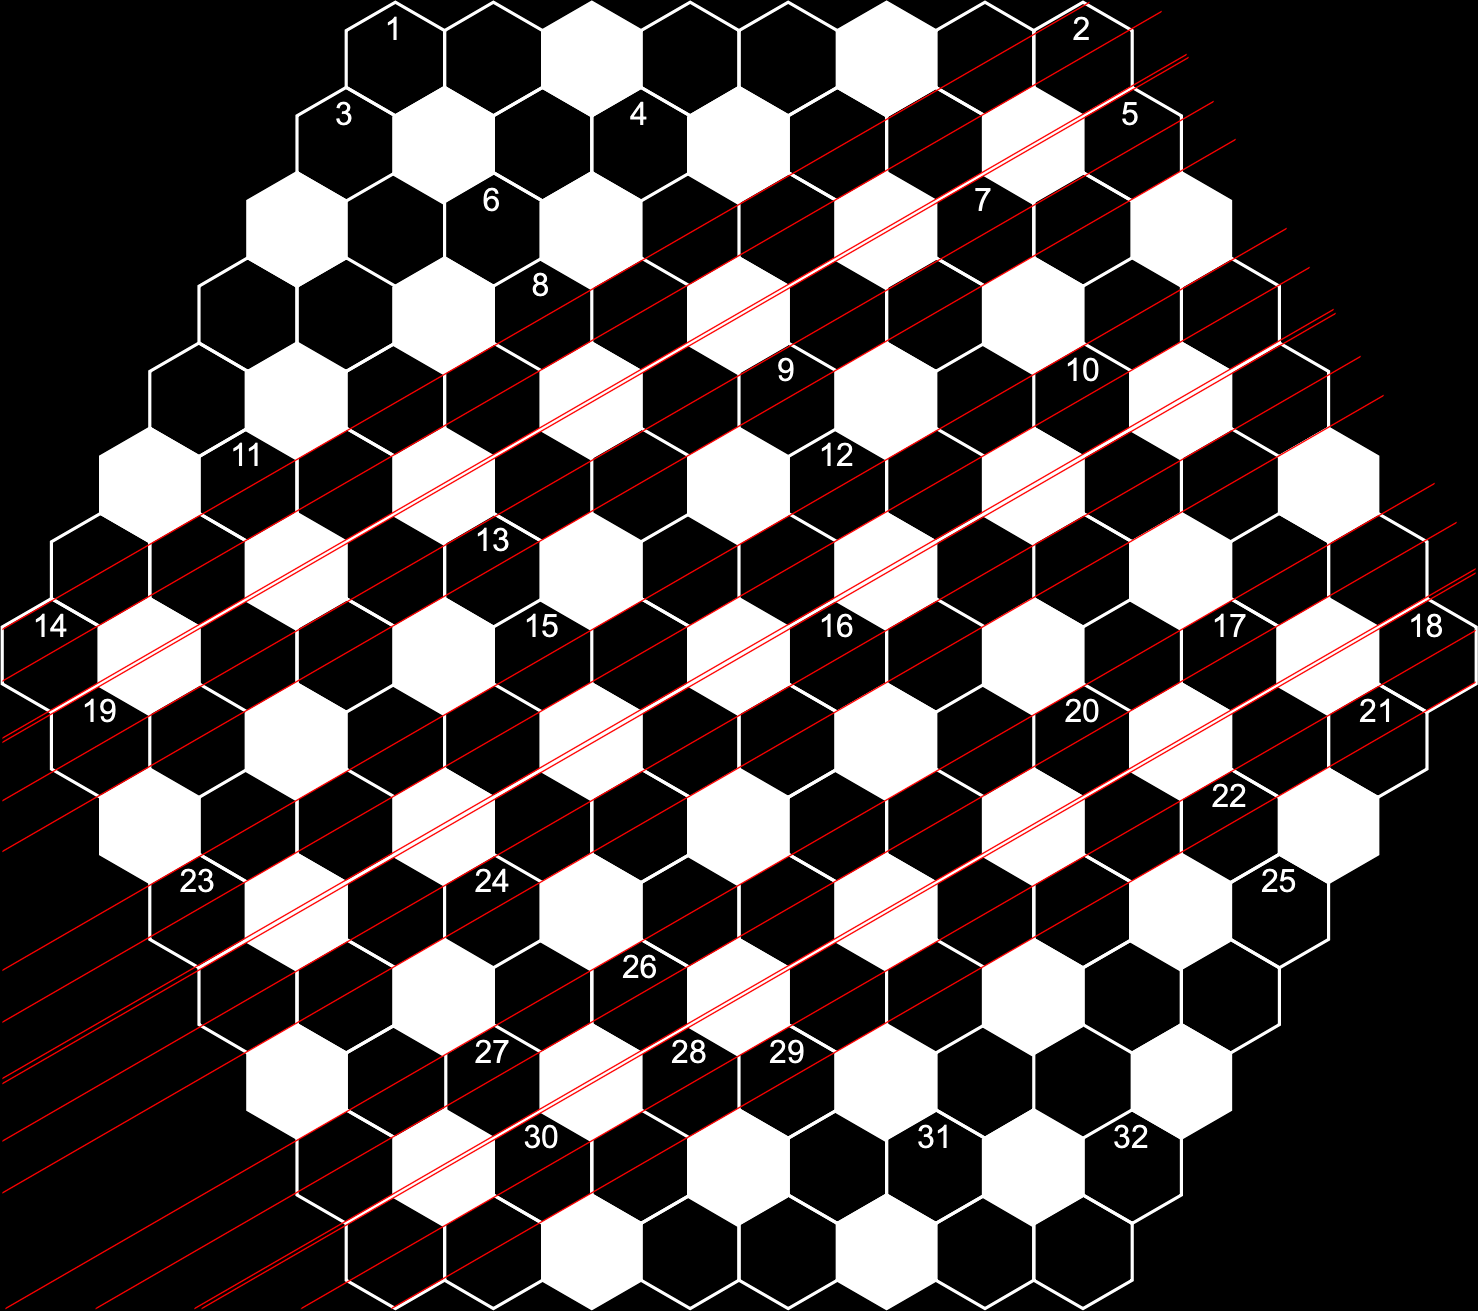

Threshold terminated at 2 41
[0, 0, 5, 62, 121, 181, 186, 242, 243, 245, 246, 247, 301, 303, 303, 305, 362, 368, 424, 483, 543, 547]
@ 0.00, with steps of 62.00: 8 divisions, 9 matches, (0 missing) 35 delta (4.38/div)
@ 0.00, with steps of 121.00: 4 divisions, 5 matches, (0 missing) 9 delta (2.25/div)
@ 0.00, with steps of 181.00: 3 divisions, 4 matches, (0 missing) 5 delta (1.67/div)
@ 0.00, with steps of 186.00: 2 divisions, 3 matches, (0 missing) 2 delta (1.00/div)
clustered: 0 18 / 21 2
intersections


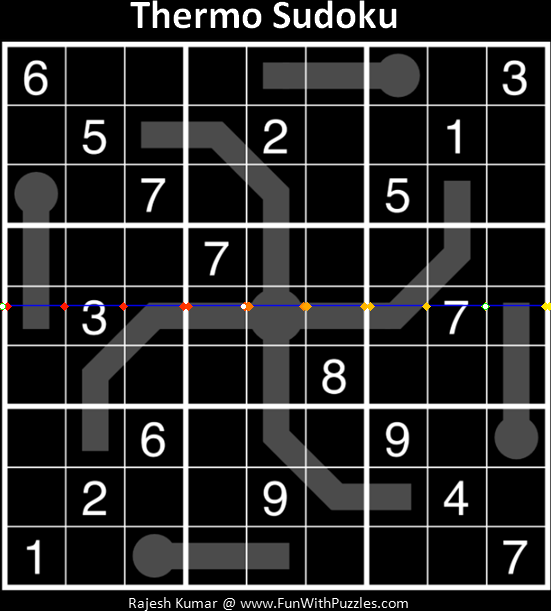

thermo.png


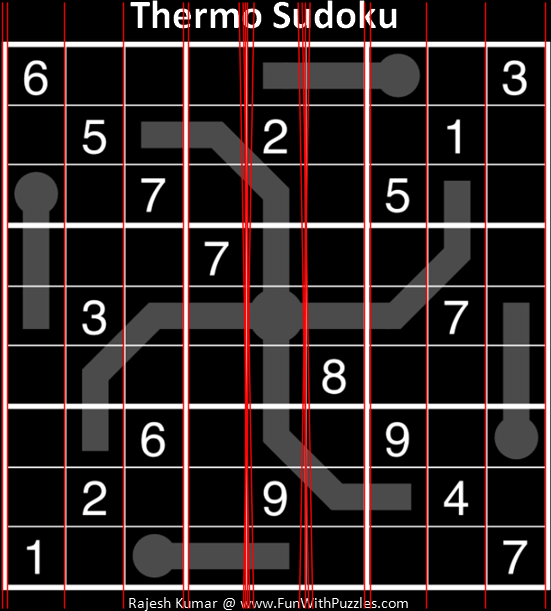

In [305]:
from data.image import lines_classifier, coloring, component, component_database, image, utils
#from util.geometry import np2d
from puzzle.constraints.image import decompose_constraints

#importlib.reload(np2d)
importlib.reload(lines_classifier)
importlib.reload(coloring)
importlib.reload(utils)
importlib.reload(decompose_constraints)
importlib.reload(decompose)
importlib.reload(image)
importlib.reload(image_problem)

#image.show = show
decompose.show = show
lines_classifier.show = show
lines_classifier.plt = plt

_FOCUS = {
   'arrow.png',
   'askew.png',
#   'cages.png',
#   'crossword.png',
#   'castlewall.png',
#   'fillomino.png',
#   'kenken.png',
#   'nonogram.png',
#   'nurimaze.png',
#   'pentopia.png',
#   'skyscraper.png',
   'pathfinder.png',
   'thermo.png',
#   'rowsgarden.png',
#   'slitherlink.png',
#   'spiral.png',
#   'strimko.png',
}


for n, i in imgs():
  p = image_problem.ImageProblem(n, i)
  #show(p._decompose.get_debug_data())
  src = p._prepare_image.get_debug_data()
  height, width = src.shape[:2]
  threshold = int(min(width, height) // 2)
  #show('src', src)
  # Edge detection
  dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)
  classified = lines_classifier.LinesClassifier(src)
  #show('canny', classified._canny)
  #continue
  groups = classified.filtered_line_groups()
  #plt.plot(list(math.degrees(line[1]) for group in groups for line in group))
  #plt.show()
  #print('n groups:', len(groups))
  for color, group in zip(coloring.colors(len(groups)), groups):
    color = color.tolist()
    #print('group with theta', math.degrees(group[0][1]), 'is color', color)
    for rho, theta in group:
      a = math.cos(theta)
      b = math.sin(theta)
      x0 = a * rho
      y0 = b * rho
      pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
      pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
      #print(pt1, pt2)
      cv2.line(dst, pt1, pt2, color, 1, cv2.LINE_AA)
  show(n, dst)

In [247]:
np.round(np.array([[.4], [1.4]]))

array([[0.],
       [1.]])

working on (414x373)


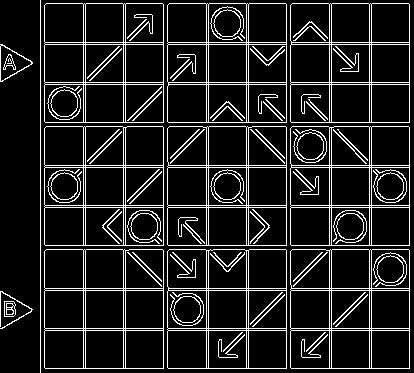

completed


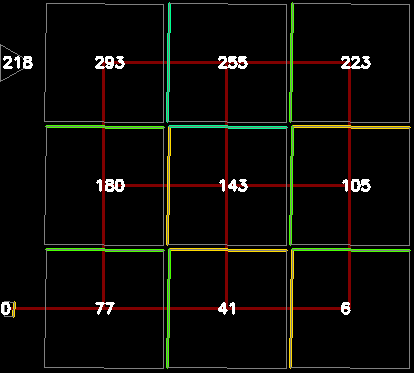

working on (420x364)


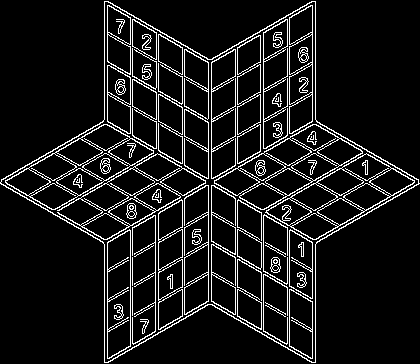

completed


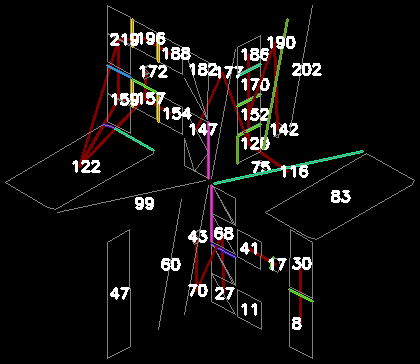

working on (551x611)


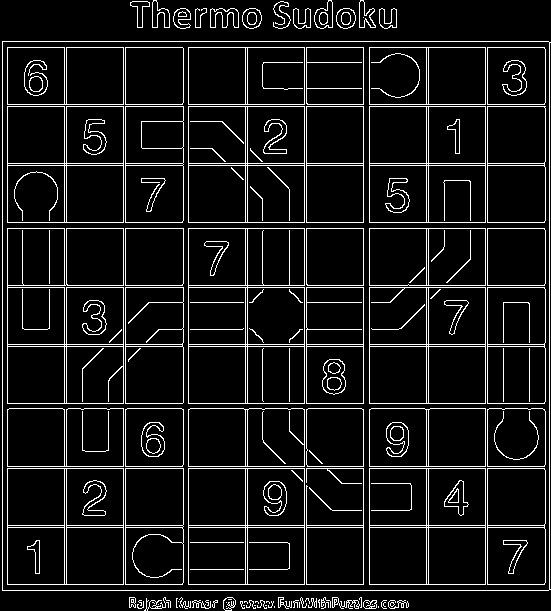

completed


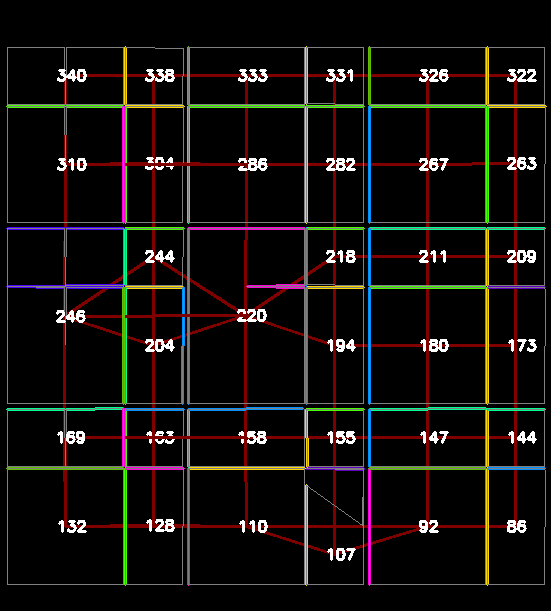

In [197]:
from data.image import contours_classifier, coloring, component, component_database, image, utils
from puzzle.constraints.image import decompose_constraints

importlib.reload(contours_classifier)
importlib.reload(coloring)
importlib.reload(utils)
importlib.reload(decompose_constraints)
importlib.reload(decompose)
importlib.reload(image)
importlib.reload(image_problem)


contours_classifier.show = show


_FOCUS = {
  'askew.png',
   'arrow.png',
#   'cages.png',
#   'castlewall.png',
#   'fillomino.png',
#   'kenken.png',
#   'nonogram.png',
#  'pathfinder.png',
   'thermo.png',
#  'rowsgarden.png',
#   'slitherlink.png',
#  'spiral.png',
#   'strimko.png',
}


for n, i in imgs():
  p = image_problem.ImageProblem(n, i)
  #show(p._decompose.get_debug_data())
  src = p._prepare_image.get_debug_data()
  height, width = src.shape[:2]
  threshold = int(min(width, height) // 2)
  #show('src', src)
  # Edge detection
  #canny = cv2.Canny(src, 50, 200, None, 3)
  #kernel = np.ones((2, 2))
  #cv2.dilate(canny, kernel, iterations = 1, dst=canny)
  dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)
  classified = contours_classifier.ContoursClassifier(src)
  #show(classified._tmp_image)

In [ ]:
# WIP source from grid.py:
from data import lazy

class Grid(object):
  def grid_without_threshold(self) -> np.ndarray:
    # TODO: Keep metadata on component positions.
    grayscale = np.copy(self.grayscale_inv)
    for mask, color in itertools.chain(
        self._layer_masks(), self._component_masks(include_inverted=True)):
      if color == 0:
        weight = -1
      else:
        weight = 1
      cv2.addWeighted(grayscale, 1, utils.antialias(mask), weight, 0, dst=grayscale)
    return grayscale

  @lazy.prop
  def grid(self) -> np.ndarray:
    src = np.array(np.where(self.grid_without_threshold > _THRESHOLD, _MAX, 0), dtype=np.uint8)
    return utils.preserve_stroke(src, _MAX, .9)

  def _layer_masks(self, n: int = 6, show = lambda *x: None) -> Iterable[Tuple[np.ndarray, int]]:
    src = self.grayscale_inv
    show(src)
    # DO NOT SUBMIT: "show" param.
    batches = list(reversed(list(
        coloring.top_n_color_clusters(self._grayscale_inv_bincount, n))))
    print(batches)
    kernel_size = 5
    kernel = utils.kernel_circle(kernel_size)
    # Normalized kernal used during blurring. Multiply 2x to intensify.
    kernel_normalized = 2 * kernel / np.count_nonzero(kernel)
    forbidden_zone = np.zeros_like(src)
    blocked_next = forbidden_zone
    for batch in batches:
      low, high = batch[0] - _THRESHOLD, batch[-1] + _THRESHOLD
      targeted = np.where(((low < src) & (src < high)), src, 0)
      blocked_count = np.count_nonzero((targeted != 0) & (blocked_next != 0))
      print('blocked count:', blocked_count, 100 * blocked_count / src.size)
      if low > 0 and high < _MAX:
        print('targeted batch %s [%s, %s] (%s)' % (batch, low, high, kernel_size))
        show(targeted)
        show('brighter', np.where(src > high, 255, 0))
        # WARNING: 1.75 is very finely tuned. Any lower and grid lines are
        # removed.
        opened = utils.preserve_stroke(targeted, low, 1.75)
        if not np.any(opened):
          continue
        #opened_percent = 100 * np.count_nonzero(targeted) / opened.size
        #if opened_percent < 1: continue
        #print('opened %.02f' % opened_percent)
        show('opened', opened)
        yield opened, 0
        if show:
          blurred = cv2.filter2D(
              opened,
              cv2.CV_8UC1,
              kernel_normalized,
              borderType=cv2.BORDER_ISOLATED)
          print('blurred')
          show(blurred)
          subtracted = src - blurred
          result = np.array(np.where(src < blurred, 0, subtracted), dtype=np.uint8)
          show('result', result)
          show('nonzero', np.array(np.where(result > 0, 255, 0), dtype=np.uint8))
      # Mark more territory as forbidden.
      np.maximum(forbidden_zone, targeted, out=forbidden_zone)
      blocked_next = cv2.dilate(forbidden_zone, kernel, iterations=2)
      show('blocked_next', blocked_next)